# **SAUDI ARABIA RBC estimation**

##### PSME 2023-2024 Macroeconomics TD-Group: 
- Cameron Ann Jessie
- Landini Elia
- Molitor Maurice

##### The following notebook houses our Saudi Arabia RBC Estimation Project, an endeavor aimed at employing Real Business Cycle (RBC) modeling to analyze economic fluctuations in Saudi Arabia over a timeframe spanning over 40 years. Through statistical and econometric techniques, we aim to uncover the underlying factors driving macroeconomic dynamics in the Saudi context.

## **INTRODUCTORY SETUP**

In [7]:
#Packages download
!pip install aiohttp --only-binary :all:
#!pip install github -q
!pip install pandas -q
!pip install pandas_datareader -q
!pip install prettytable -q
!pip install statsmodels -q
!pip install gatspy -q
!pip install wbgapi -q
!pip install wbdata -q
!pip install requests beautifulsoup4 pandas -q
!pip install gEconpy -q
!pip install joblib -q
!pip install tsdisagg -q
!pip install scikit-learn -q

In [9]:
### other setup stuff
%matplotlib inline
import sys

sys.path.append("..")

import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import arviz as az
from pandas_datareader.fred import FredReader

config = {
    "figure.figsize": (14, 4),
    "figure.dpi": 144,
    "figure.facecolor": "white",
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "axes.spines.left": False,
    "axes.spines.right": False,
}

plt.rcParams.update(config)

### **Creating Helper Functions**

In [10]:
def make_var_names(var, n_lags, reg):
    names = [f'L1.{var}']
    for lag in range(1, n_lags + 1):
        names.append(f'D{lag}L1.{var}')
    if reg != 'n':
        names.append('Constant')
    if 't' in reg:
        names.append('Trend')

    return names

def ADF_test_summary(df, maxlag=None, autolag='BIC', missing='error'):
    if missing == 'error':
        if df.isna().any().any():
            raise ValueError("df has missing data; handle it or pass missing='drop' to automatically drop it.")
            
    if isinstance(df, pd.Series):
        df = df.to_frame()
        
    for series in df.columns:
        data = df[series].copy()
        if missing == 'drop':
            data.dropna(inplace=True)
            
        print(series.center(110))
        print(('=' * 110))
        line = 'Specification' + ' ' * 15 + 'Coeff' + ' ' * 10 + 'Statistic' + ' ' * 5 + 'P-value' + ' ' * 6 + 'Lags' + ' ' * 6 + '1%'
        line += ' ' * 10 + '5%' + ' ' * 8 + '10%'
        print(line)
        print(('-' * 110))
        spec_fixed = False
        for i, (name, reg) in enumerate(zip(['Constant and Trend', 'Constant Only', 'No Constant'], ['ct', 'c', 'n'])):
            stat, p, crit, regresult = sm.tsa.adfuller(data, regression=reg, regresults=True, maxlag=maxlag,
                                                       autolag=autolag)
            n_lag = regresult.usedlag
            gamma = regresult.resols.params[0]
            names = make_var_names(series, n_lag, reg)
            reg_coefs = pd.Series(regresult.resols.params, index=names)
            reg_tstat = pd.Series(regresult.resols.tvalues, index=names)
            reg_pvals = pd.Series(regresult.resols.pvalues, index=names)

            line = f'{name:<21}{gamma:13.3f}{stat:15.3f}{p:13.3f}{n_lag:11}{crit["1%"]:10.3f}{crit["5%"]:12.3f}{crit["10%"]:11.3f}'
            print(line)

            for coef in reg_coefs.index:
                if coef in name:
                    line = f"\t{coef:<13}{reg_coefs[coef]:13.3f}{reg_tstat[coef]:15.3f}{reg_pvals[coef]:13.3f}"
                    print(line)
                    
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None, **plot_kwargs):
    figsize = plot_kwargs.get('figsize', (14,8))
    fig = plt.figure(figsize=figsize)
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.1)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)
    plt.show()

def plot_df(df, **plot_kwargs):
    fig = plt.figure(figsize=(14,6), dpi=144)
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=df.shape[1])

    for loc, var in zip(plot_locs, df):
        axis = fig.add_subplot(gs[loc])
        df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

    fig.tight_layout()
    plt.show()

In [11]:
vars_to_plot = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'Rt', 'N','K', 'CA', 'CPI', 'Ex_Rate', 'Oil']


## **CHAPTER 1: DATA**

### OVERVIEW on DATA IMPORT & ADJUSTMENT REQUIREMENTS

#### DATA REQUIREMENTS
(N.B. the following table has not descriptive purposes, but it is rather intended as an auxiliary tool for the editors)

| Step | Imported? | Season adjusted? | Currency adjusted? | Variable | Variable Name | Shortcut | Note | Source | Link | Date |
|------|-----------|-------------------|---------------------|----------|---------------|----------|------|--------|------|------|
| 1b    | Yes       |        Yes        | millions USD               | Y       | Real GDP      | NGDPRSAXDCSAQ | USD, SA, Quarterly | FRED | [Link](https://fred.stlouisfed.org/series/NGDPRSAXDCSAQ) | 2010 - current |
| 1a    | Yes       |        no        | millions USD               | Y_yearly       | Real GDP in current      | NY.GDP.MKTP.CD | Domestic Currency, SA, Quarterly | Worldbank | [Link](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD) | 1960 - current |
| 2    | Yes       |        Yes           | millions USD                | C        | Real Private Sector Final Consumption Expenditure | NCPRNSAXDCSAQ | Domestic Currency, Not SA, Quarterly | FRED | [Link](https://fred.stlouisfed.org/series/NCPRNSAXDCSAQ) | 2010 - current |
| 3    | Yes       | Yes          | millions USD                | I       | Gross Fixed Capital Formation | NE.GDI.FTOT.CD | Current US Dollar, Annual | WorldBank | [Link](https://data.worldbank.org/indicator/NE.GDI.FTOT.CD?locations=SA) | 1968-2022 |
| 4    | Yes       | Yes                | millions USD                  | TB      | Trade Balance | BN.GSR.GNFS.CD | Net trade in goods and services (BOP, current US$) | World Bank | [Link](https://data.worldbank.org/indicator/BN.GSR.GNFS.CD?locations=SA) | 1971-2022 |
| 5    | Yes        | Yes         | hours       | N       | Average Hours of Work for Employed Persons | Manually Imported | Measures the average weekly working hours of workers (15 years and over) | General Statistics Authority | [Link](https://database.stats.gov.sa/home/indicator/999118) | Q2 2016-Q2 2023 |
| 6    | Yes        |     Yes              |         USD            | w       | Average Monthly Wages for Paid Employees | Manually Imported | The sum of the monthly wages to the total of employed persons for wages | General Statistics Authority | [Link](https://database.stats.gov.sa/home/indicator/999118) | Q2 2016-Q2 2023 |
| 7    | Yes       |       Yes            | In %                |  Rt    | Real Long Term Bond Rate | Manually Imported | 10-year government development bond yield, Quarterly | National Statistics, Saudi Central Bank | [Link](https://www.sama.gov.sa/en-US/GovtSecurity/pages/governmentdevelopmentbonds.aspx), [Specific Bond (19Jan2029)](https://cbonds.com/bonds/461405/) | Q1999-Q32007, Past 3 yrs |
| 8    | Yes       |                   | In %                | r       | Short Term Bond Rate | Manually Imported | Quarterly average of interbank rate | Saudi Central Bank | [Link](https://www.sama.gov.sa/ar-sa/EconomicReports/Pages/report.aspx?cid=118) | 2007-current |
| 9    | Yes       |                   | Riyal               | K       | Capital Stock at Constant National Prices | RKNANPSAA666NRUG | Millions of 2017 U.S. Dollars, Not SA, Annual | FRED | [Link](https://fred.stlouisfed.org/series/RKNANPSAA666NRUG) | 1970-2019 |
| 10   | Yes       |                   | In %                | CA      | Current Account | BN.CAB.XOKA.GD.ZS | Current account balance % of GDP, Annual | Worldbank | [Link](https://data.worldbank.org/indicator/BN.CAB.XOKA.GD.ZS?locations=SA) | 1970-2021 |
| 11   | Yes       |                   | In %                |  CPI           | Consumer Prices | FP.CPI.TOTL.ZG |Inflation, consumer prices (annual %) - Saudi Arabia|  Worldbank |  [Link](https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=SA) | 1964-2021 |
| 12   | Yes       |    constant  |   monthly data          |                    Ex_Rate       | Exchange Rate  | SAUCCUSMA02STM | The Saudi riyal has been at a fixed rate to the US dollar since June 1986 (SAR 3.7500 per USD) | Constant | [Link](https://fred.stlouisfed.org/series/SAUCCUSMA02STM) | 1965-2023 |
| 13   | YES | Not Seasonally Adjusted        | Dollars per Barrel    | Oil      | Crude Oil, Brent Prices | DCOILWTICO | Crude oil, average spot price of Brent, Dubai and West Texas Intermediate, equally weighed, Monthly | FRED | [Link](https://fred.stlouisfed.org/series/DCOILWTICO) | 1986 -2023 |


### DATA Import and Merging

In [12]:
import os
print(os.getcwd())

C:\Users\mauri\Documents\GitHub\Macro\Uni-projects


In [13]:
fred_indicators = ['NGDPRSAXDCSAQ', # Real Gross Domestic Product¶ quarterly
              'NCPRNSAXDCSAQ', # Real Private Sector Final Consumption Expenditure 
              'RKNANPSAA666NRUG', # Capital Stock
                'SAUCCUSMA02STM', # Ex_rate
                   'DCOILWTICO'] # Oil

wb_indicators = ['NY.GDP.MKTP.CD', # Real Gross Domestic Product¶ yearly
                'NE.GDI.FTOT.CD', # Investment
                'BN.GSR.GNFS.CD', #Trade Balance
               'BN.CAB.XOKA.GD.ZS', #Consumer Prices
             'FP.CPI.TOTL.ZG'] #Current Account

rename_dict = {'NGDPRSAXDCSAQ': 'Y',
               'NY.GDP.MKTP.CD': 'Y_yearly',
                'NE.GDI.FTOT.CD': 'I',
               'NCPRNSAXDCSAQ': 'C',
               'BN.GSR.GNFS.CD': 'TB',
               'BN.CAB.XOKA.GD.ZS': 'CA',
               'RKNANPSAA666NRUG': 'K',
                'SAUCCUSMA02STM': 'Ex_Rate',
              'FP.CPI.TOTL.ZG': 'CPI',
              'DCOILWTICO': 'Oil'}

from pandas_datareader.fred import FredReader
from pandas_datareader import wb
import pandas as pd
import os 

# check if the data is already downloaded
if not os.path.isfile('Data_Stored/SA_combined_data.csv'):
    # If it's not, download it and save it
    df_fred = FredReader(symbols=fred_indicators, start='1987', end=None).read() #starting in 1987 because of the exchange rate
    df_wb = wb.download(indicator=wb_indicators, country=['SA'], start='1987', end=None) #starting in 1987 because of the exchange rate

    df_wb = df_wb.droplevel(level=0)
    df_wb.index = pd.to_datetime(df_wb.index)

    data = df_fred.join(df_wb).rename(columns=rename_dict)
    data.to_csv('Data_Stored/SA_combined_data.csv')

else:
    # Otherwise, load it from disk
    file_path = 'Data_Stored/SA_combined_data.csv'
    df = pd.read_csv(file_path, parse_dates=['DATE'])
    # Convert DATE column to datetime if it's not already and set index
    df['DATE'] = pd.to_datetime(df['DATE'])
    df.set_index('DATE', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   C         55 non-null     float64
 2   K         33 non-null     float64
 3   Ex_Rate   442 non-null    float64
 4   Oil       9317 non-null   float64
 5   Y_yearly  36 non-null     float64
 6   I         36 non-null     float64
 7   TB        36 non-null     float64
 8   CA        36 non-null     float64
 9   CPI       36 non-null     float64
dtypes: float64(10)
memory usage: 840.0 KB


In [14]:
#print(df.head)
#print(df.dtypes)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   C         55 non-null     float64
 2   K         33 non-null     float64
 3   Ex_Rate   442 non-null    float64
 4   Oil       9317 non-null   float64
 5   Y_yearly  36 non-null     float64
 6   I         36 non-null     float64
 7   TB        36 non-null     float64
 8   CA        36 non-null     float64
 9   CPI       36 non-null     float64
dtypes: float64(10)
memory usage: 840.0 KB


In [15]:
## DATA Import of None Fred and WorldBank Data

In [16]:
#Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Average Hours of Work for Employed Persons
import pandas as pd

# Convert function to consistent quarterly format
def convert_to_quarterly_format(key):
    year, quarter = key.split(' / Q')
    return f"{year}-{quarter}"

def create_dataframe(data, column_name):
    df_manual = pd.DataFrame.from_dict(data, orient='index', columns=[column_name])
    df_manual.index = pd.to_datetime(df_manual.index.map(convert_to_quarterly_format))
    return df_manual

# Data and format for each dataset
N_data = {
    '2016 / Q2': [38.96775504],
    '2016 / Q3': [38.57034481],
    '2016 / Q4': [38.75315665],
    '2017 / Q1': [39.09336699],
    '2017 / Q2': [38.85986074],
    '2017 / Q3': [38.9159003],
    '2017 / Q4': [39.58174661],
    '2018 / Q1': [38.64750733],
    '2018 / Q2': [38.80551713],
    '2019 / Q1': [38.94281089],
    '2019 / Q2': [38.43955095],
    '2019 / Q3': [38.17616634],
    '2019 / Q4': [37.88810263],
    '2020 / Q1': [38.35162171],
    '2020 / Q2': [39.31892759],
    '2020 / Q3': [39.65375889],
    '2020 / Q4': [40.16204173],
    '2021 / Q1': [39.01231081],
    '2021 / Q2': [38.43177217],
    '2021 / Q3': [39.30209818],
    '2021 / Q4': [40.29776716],
    '2022 / Q1': [39.84260952],
    '2022 / Q2': [40.12209799],
    '2022 / Q3': [40.72582419],
    '2022 / Q4': [40.11837913],
    '2023 / Q1': [40.01679873],
    '2023 / Q2': [40.35208325]
}
w_data = {
    '2016 / Q2': [10462.10642],
    '2016 / Q3': [9712.357822],
    '2016 / Q4': [10227.10574],
    '2017 / Q1': [9884.23959],
    '2017 / Q2': [9910.831884],
    '2017 / Q3': [10011.63187],
    '2017 / Q4': [9939.325367],
    '2018 / Q1': [10088.82327],
    '2018 / Q2': [10237.6998],
    '2019 / Q1': [10299.10765],
    '2019 / Q2': [10341.84075],
    '2019 / Q3': [10273.0132],
    '2019 / Q4': [10256.36242],
    '2020 / Q1': [10302.70319],
    '2020 / Q2': [9970.297977],
    '2020 / Q3': [9971.056802],
    '2020 / Q4': [10539.69348],
    '2021 / Q1': [10599.8789],
    '2021 / Q2': [10491.248],
    '2021 / Q3': [10474.12402],
    '2021 / Q4': [10185.54969],
    '2022 / Q1': [9811.756473],
    '2022 / Q2': [10430.41218],
    '2022 / Q3': [9583.143722],
    '2022 / Q4': [9701.453807],
    '2023 / Q1': [9893.242042],
    '2023 / Q2': [9923.604891]
}
Rt_data = {
    '2001 / Q1': [5.74],
    '2001 / Q2': [6.79],
    '2001 / Q3': [6.36],
    '2002 / Q1': [3.5],
    '2002 / Q2': [5.05],
    '2002 / Q3': [5.74],
    '2002 / Q4': [6.36],
    '2003 / Q1': [2.69],
    '2003 / Q2': [3.72],
    '2003 / Q3': [4.36],
    '2003 / Q4': [3.6],
    '2004 / Q1': [2.75],
    '2004 / Q2': [2.75],
    '2004 / Q3': [2.0],
    '2004 / Q4': [5.194],
    '2005 / Q1': [5.25],
    '2005 / Q2': [5.25],
    '2005 / Q3': [4.625],
    '2005 / Q4': [4.625],
    '2006 / Q1': [5.25],
    '2006 / Q2': [5.25],
    '2006 / Q3': [5.5],
    '2006 / Q4': [5.5],
    '2007 / Q1': [5.0],
    '2007 / Q2': [5.0],
    '2007 / Q3': [5.0],
    '2007 / Q4': [5.0]
}

rt_data = {
    '2007 / Q1': [5.086876667],
    '2007 / Q2': [5.044793333],
    '2007 / Q3': [5.05125],
    '2007 / Q4': [4.4375],
    '2008 / Q1': [2.750729167],
    '2008 / Q2': [2.497683913],
    '2008 / Q3': [4.017900408],
    '2008 / Q4': [3.872003205],
    '2009 / Q1': [1.357266144],
    '2009 / Q2': [0.889771282],
    '2009 / Q3': [0.647518846],
    '2009 / Q4': [0.750644872],
    '2010 / Q1': [0.760368333],
    '2010 / Q2': [0.726157867],
    '2010 / Q3': [0.721976538],
    '2010 / Q4': [0.734948077],
    '2011 / Q1': [0.75],
    '2011 / Q2': [0.714846092],
    '2011 / Q3': [0.604153205],
    '2011 / Q4': [0.708867179],
    '2012 / Q1': [0.832301795],
    '2012 / Q2': [0.906203974],
    '2012 / Q3': [0.95003641],
    '2012 / Q4': [0.976722821],
    '2013 / Q1': [0.97589924],
    '2013 / Q2': [0.95818661],
    '2013 / Q3': [0.958199266],
    '2013 / Q4': [0.920658071],
    '2014 / Q1': [0.953805303],
    '2014 / Q2': [0.951747835],
    '2014 / Q3': [0.945912698],
    '2014 / Q4': [0.891596032],
    '2015 / Q1': [0.8162],
    '2015 / Q2': [0.773933333],
    '2015 / Q3': [0.828233333],
    '2015 / Q4': [1.1004],
    '2016 / Q1': [1.715762063],
    '2016 / Q2': [2.072859778],
    '2016 / Q3': [2.280601229],
    '2016 / Q4': [2.195467532],
    '2017 / Q1': [1.886523287],
    '2017 / Q2': [1.741016667],
    '2017 / Q3': [1.794616026],
    '2017 / Q4': [1.82451746],
    '2018 / Q1': [1.9542],
    '2018 / Q2': [2.414533333],
    '2018 / Q3': [2.6192],
    '2018 / Q4': [2.815995514],
    '2019 / Q1': [2.934282911],
    '2019 / Q2': [2.821566807],
    '2019 / Q3': [2.513837534],
    '2019 / Q4': [2.257692993],
    '2020 / Q1': [1.886206605],
    '2020 / Q2': [1.127925385],
    '2020 / Q3': [0.916],
    '2020 / Q4': [0.839034731],
    '2021 / Q1': [0.807223763],
    '2021 / Q2': [0.793675606],
    '2021 / Q3': [0.796229903],
    '2021 / Q4': [0.842836559],
    '2022 / Q1': [1.364613437],
    '2022 / Q2': [2.714606047],
    '2022 / Q3': [3.140852573],
    '2022 / Q4': [5.281579513],
    '2023 / Q1': [5.494883633],
    '2023 / Q2': [5.830097591],
    '2023 / Q3': [6.088936188],
}


# Create dataframes
df_N = create_dataframe(N_data, 'N')
df_w = create_dataframe(w_data, 'w')
df_Rt = create_dataframe(Rt_data, 'Rt')
df_rt = create_dataframe(rt_data, 'rt')

dataframes = [df_N, df_w, df_Rt, df_rt]

# Merge dataframes
#merged_df_manual.drop(columns=merged_df_manual.columns[0], inplace=True)

# Fill NaN values in the index with a default date
#merged_df_manual.index = merged_df_manual.index.fillna('DEFAULT_DATE')

# Merge dataframes (assuming you want to merge them all)
merged_df = df_N.join(df_w, how='outer').join(df_Rt, how='outer').join(df_rt, how='outer')

# To view the merged dataframe
print(merged_df.head())
print(merged_df['N'])
print(merged_df['w'])
print(merged_df['Rt'])
print(merged_df['rt'])
print(merged_df['N'].dropna())
print(merged_df['w'].dropna())
print(merged_df['Rt'].dropna())
print(merged_df['rt'].dropna())



             N   w    Rt  rt
2001-01-01 NaN NaN  5.74 NaN
2001-02-01 NaN NaN  6.79 NaN
2001-03-01 NaN NaN  6.36 NaN
2002-01-01 NaN NaN  3.50 NaN
2002-02-01 NaN NaN  5.05 NaN
2001-01-01          NaN
2001-02-01          NaN
2001-03-01          NaN
2002-01-01          NaN
2002-02-01          NaN
                ...    
2022-03-01    40.725824
2022-04-01    40.118379
2023-01-01    40.016799
2023-02-01    40.352083
2023-03-01          NaN
Name: N, Length: 90, dtype: float64
2001-01-01            NaN
2001-02-01            NaN
2001-03-01            NaN
2002-01-01            NaN
2002-02-01            NaN
                 ...     
2022-03-01    9583.143722
2022-04-01    9701.453807
2023-01-01    9893.242042
2023-02-01    9923.604891
2023-03-01            NaN
Name: w, Length: 90, dtype: float64
2001-01-01    5.74
2001-02-01    6.79
2001-03-01    6.36
2002-01-01    3.50
2002-02-01    5.05
              ... 
2022-03-01     NaN
2022-04-01     NaN
2023-01-01     NaN
2023-02-01     NaN
2023-03-01    

In [17]:
#merge all data
df.info()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   C         55 non-null     float64
 2   K         33 non-null     float64
 3   Ex_Rate   442 non-null    float64
 4   Oil       9317 non-null   float64
 5   Y_yearly  36 non-null     float64
 6   I         36 non-null     float64
 7   TB        36 non-null     float64
 8   CA        36 non-null     float64
 9   CPI       36 non-null     float64
dtypes: float64(10)
memory usage: 840.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90 entries, 2001-01-01 to 2023-03-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       27 non-null     float64
 1   w       27 non-null     float64
 2   Rt      27 non-null     float64
 3   rt      67 non-null     float64
dtypes: float64(4)
m

In [18]:
# Merge 'df' and 'merged_df' based on their DatetimeIndex
merged_df_aligned = merged_df.reindex(df.index)
final_df = merged_df_aligned.join(df, how='outer')
final_df.index.name = 'DATE'



# Display the first few rows of the merged dataframe
print(final_df.head())
final_df.info()
print(final_df.index)
print(final_df.columns)



             N   w  Rt  rt   Y   C           K  Ex_Rate    Oil      Y_yearly  \
DATE                                                                           
1987-01-01 NaN NaN NaN NaN NaN NaN  1217826.25     3.75    NaN  8.569594e+10   
1987-01-02 NaN NaN NaN NaN NaN NaN         NaN      NaN  18.13           NaN   
1987-01-05 NaN NaN NaN NaN NaN NaN         NaN      NaN  17.98           NaN   
1987-01-06 NaN NaN NaN NaN NaN NaN         NaN      NaN  18.21           NaN   
1987-01-07 NaN NaN NaN NaN NaN NaN         NaN      NaN  18.28           NaN   

                       I            TB         CA       CPI  
DATE                                                         
1987-01-01  1.913489e+10 -1.138400e+10 -11.389104 -1.547117  
1987-01-02           NaN           NaN        NaN       NaN  
1987-01-05           NaN           NaN        NaN       NaN  
1987-01-06           NaN           NaN        NaN       NaN  
1987-01-07           NaN           NaN        NaN       NaN  
<clas

In [19]:
new_order = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'N','Rt', 'K', 'CA', 'CPI', 'Ex_Rate', 'Oil']
final_df = final_df[new_order]


### DATA MANIPULATION and CLEANING

C:\Users\mauri\AppData\Local\Temp\ipykernel_36304\3110883291.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


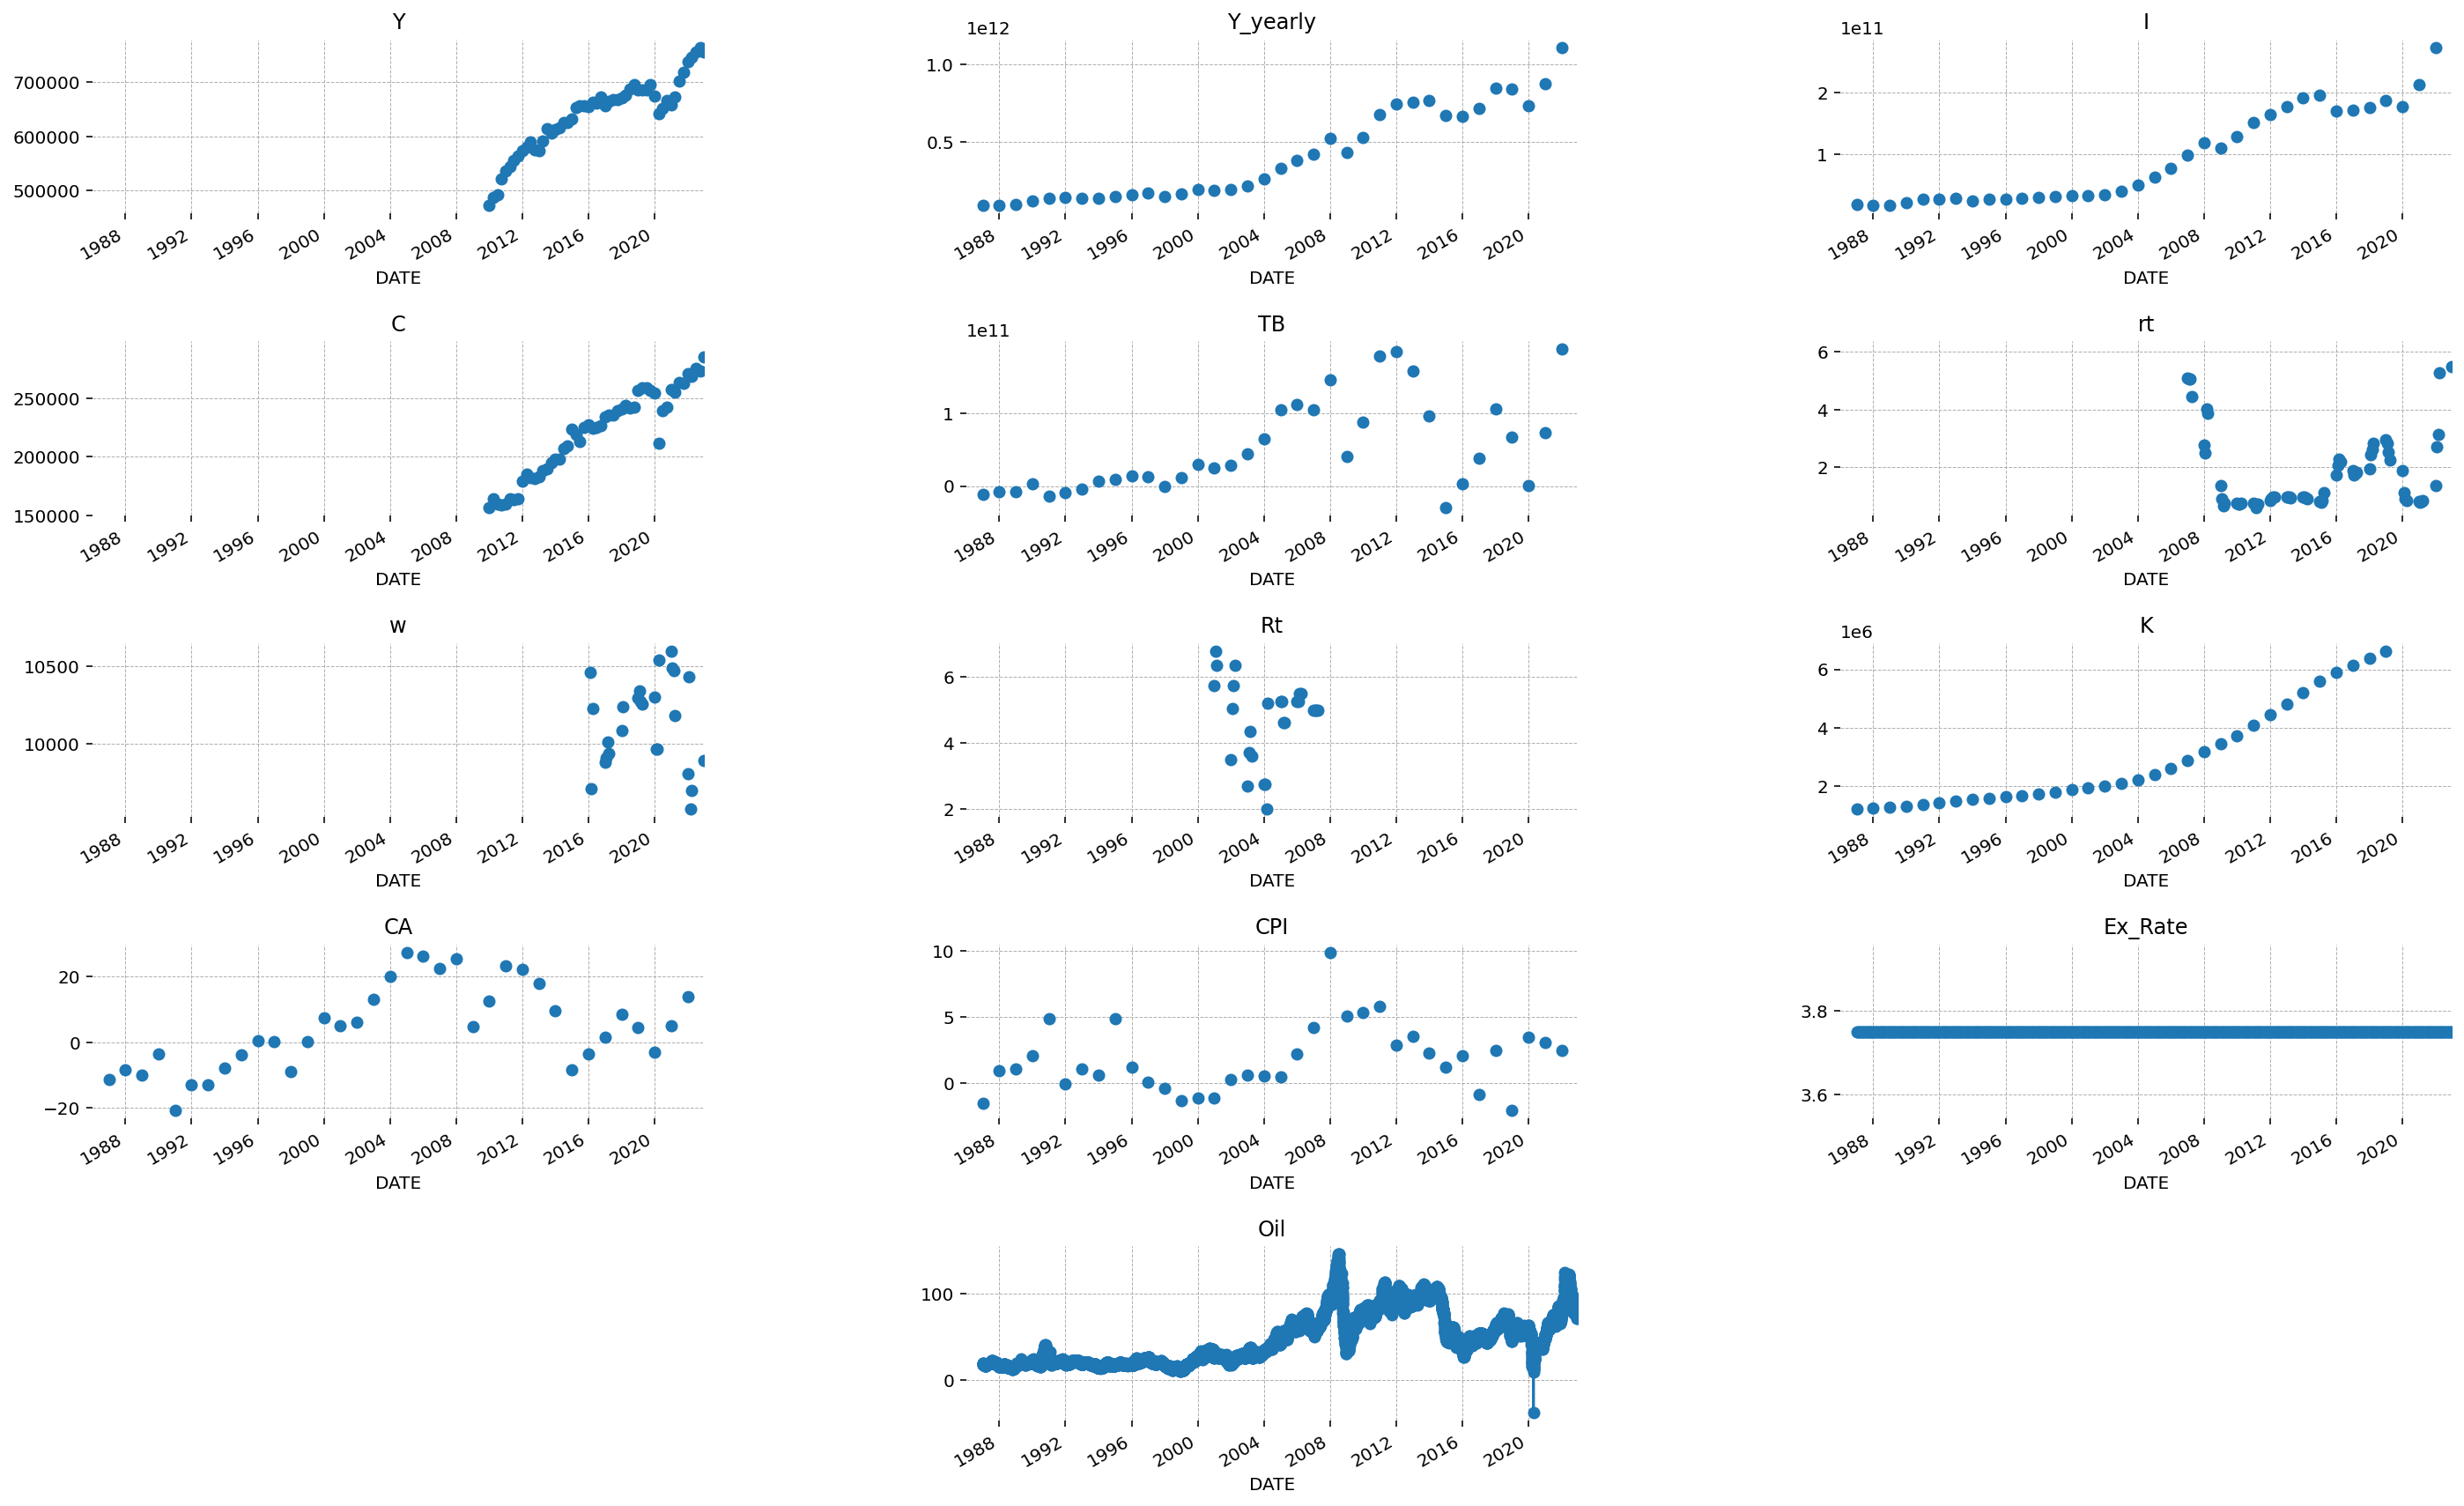

In [20]:
def plot_df(final_df, **plot_kwargs):
    columns_to_plot = ['Y', 'Y_yearly', 'I', 'C', 'TB', 'rt', 'w', 'Rt', 'K', 'CA', 'CPI', 'Ex_Rate', 'Oil']
    
    fig = plt.figure(figsize=(24, 16), dpi=144)  # Increased figure size
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(columns_to_plot))

    # Adjusting the layout for better spacing
    gs.update(hspace=5.5, wspace=1.5)  

    for loc, var in zip(plot_locs, columns_to_plot):
        if var in final_df.columns:
            axis = fig.add_subplot(gs[loc])
            final_df[var].plot(ax=axis, **plot_kwargs)
            axis.set_title(var)

            # Set x-axis limits
            axis.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2022-12-31'))

    plt.tight_layout()
    plt.show()

# Assuming 'data' is your dataframe
plot_df(final_df, marker='o')


## We can see that there is lots of Data which is not in the same time frame or format. Therefore we will need to adjust the data so we have quartely data for all of our variables.

In [80]:
#copying are data frame because stuff got fucked up too many times
final_df_copy = final_df
#final_df = final_df_copy
final_df_copy.info()
#final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   Y_yearly  36 non-null     float64
 2   I         36 non-null     float64
 3   C         55 non-null     float64
 4   TB        36 non-null     float64
 5   rt        67 non-null     float64
 6   w         27 non-null     float64
 7   N         27 non-null     float64
 8   Rt        27 non-null     float64
 9   K         33 non-null     float64
 10  CA        36 non-null     float64
 11  CPI       36 non-null     float64
 12  Ex_Rate   442 non-null    float64
 13  Oil       9317 non-null   float64
dtypes: float64(14)
memory usage: 1.4 MB


## Resampling of I 

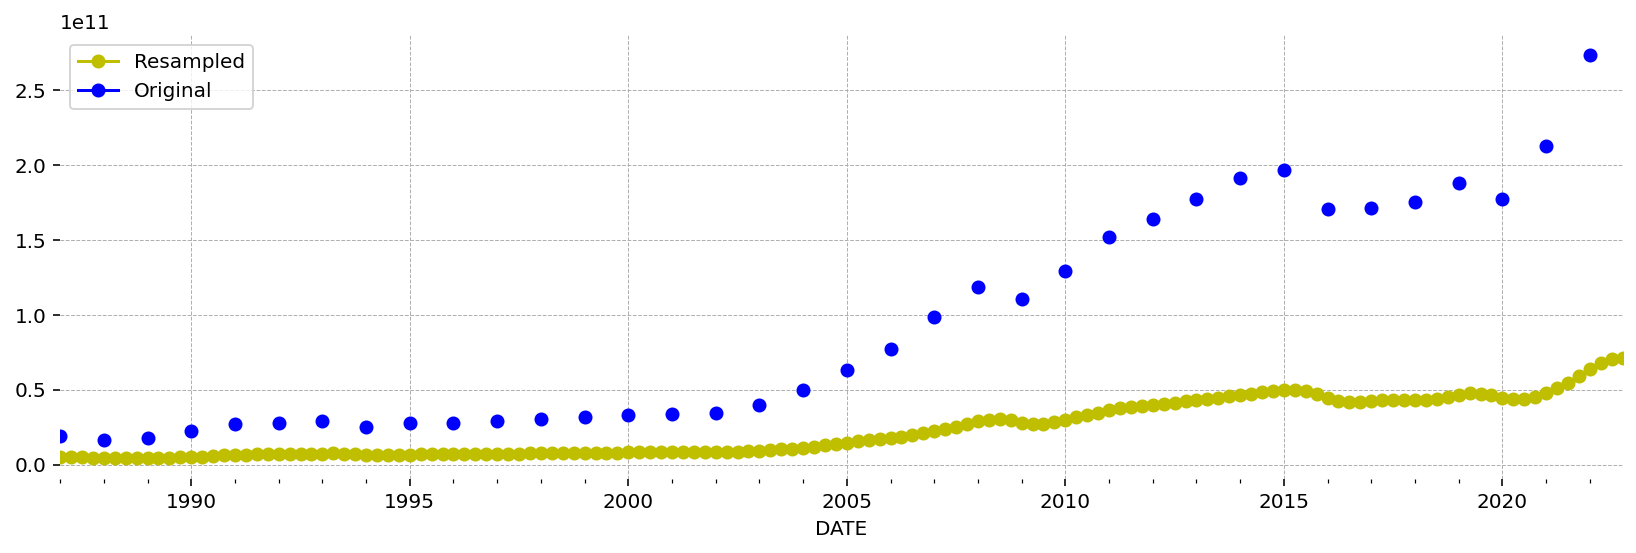

1987-01-01    4.932778e+09
1987-04-01    4.873156e+09
1987-07-01    4.753910e+09
1987-10-01    4.575042e+09
1988-01-01    4.336551e+09
                  ...     
2021-10-01    5.901167e+10
2022-01-01    6.395704e+10
2022-04-01    6.766607e+10
2022-07-01    7.013876e+10
2022-10-01    7.137510e+10
Freq: QS-OCT, Name: I, Length: 144, dtype: float64


In [81]:
#Resample Data for I, Oil, TB, Ex_rate and K 
from tsdisagg import disaggregate_series
#create a disaggregate version of I to derive quarterly data from a yearly dataframe
I_resample = final_df['I'].dropna().copy()
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
#I_resample = I_resample / 1_000_000
I_resample = disaggregate_series(I_resample, target_freq='QS', agg_func='sum')
# Plot the resampled data
I_resample.resample('QS').asfreq().plot(label='Resampled', marker='o', color='y')

# Plot the original data
final_df['I'].dropna().resample('QS').asfreq().plot(label='Original', marker='o', color='b')

# Add legend and display the plot
plt.legend()
plt.show()
print(I_resample)

We can see that the sampling method was unsuccessful. There seems to be a different trend beginning in the 2000s. We are trying to capture that to properly estimate quarterly data.

In [82]:
I_quarterly = final_df[['I']].dropna().copy()
I_quarterly = I_quarterly.sort_index()
#Sort data so frequency runs correct 
I_quarterly.head()

,I
DATE,
1987-01-01,1.913489e+10
1988-01-01,1.670377e+10
1989-01-01,1.772828e+10
1990-01-01,2.222981e+10
1991-01-01,2.683051e+10


In [83]:
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(I_quarterly, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)

Optimization terminated successfully.
         Current function value: 24.658679
         Iterations: 295
         Function evaluations: 616


C:\Users\mauri\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Users\mauri\miniconda3\envs\econ\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


Ignore warning as our data is correctly assumed to be annually

In [84]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      I   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -887.712
Date:                Mon, 01 Jan 2024   AIC                           1785.425
Time:                        23:10:29   BIC                           1793.343
Sample:                    01-01-1987   HQIC                          1788.188
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    4.22e+09   6.14e-14   6.88e+22      0.000    4.22e+09    4.22e+09
drift      -8.541e+06    1.9e-12  -4.49e+18      0.000   -8.54e+06   -8.54e+06
trend.2     5.524e+07   6.03e-11   9.17e+17      0.000    5.52e+07    5.52e+07
ar.L1          0.7700      0.011     67.508      0.000       0.748       0.792
sigma2      1.496e+20    5.3e-26   2.82e+45      0.000     1.5e+20     1.5e+20
===================================================================================
Ljung-Box (L1) (Q):                   3.57   Jarque-Bera (JB):                 8.46
Prob(Q):                              0.06   Prob(JB):                         0.01
Heteroskedasticity (H):              52.43   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.25e+65. Standard errors may be unstable.
"""

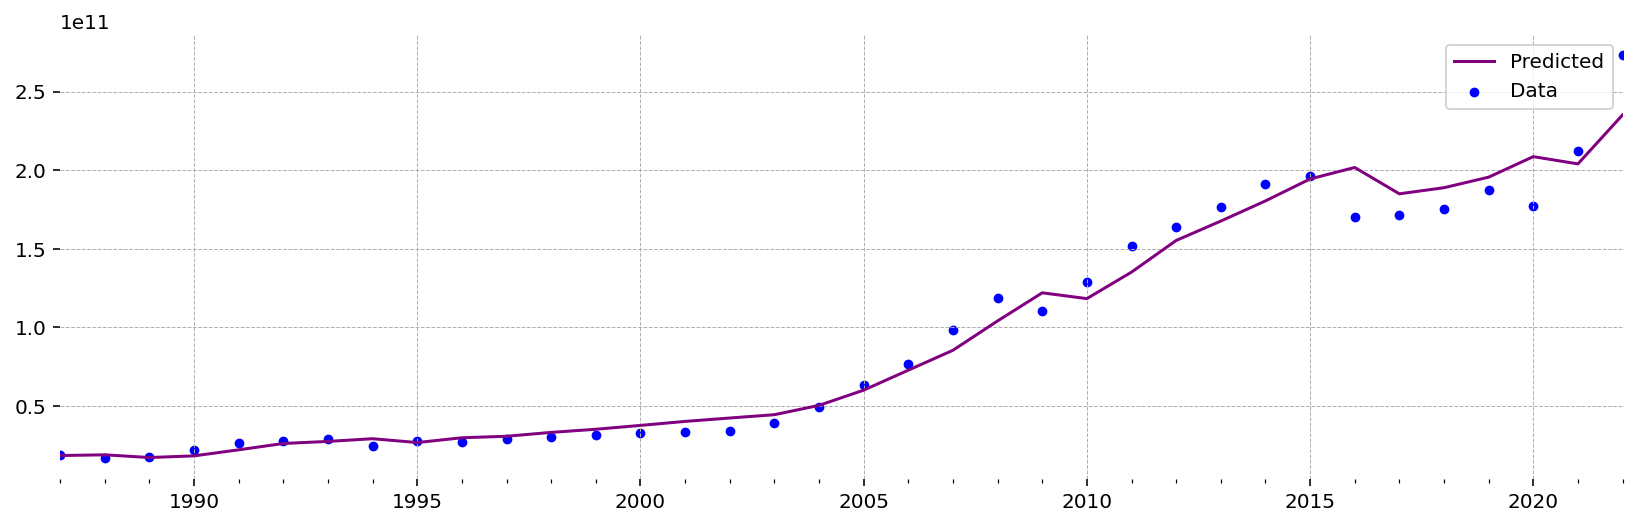

In [85]:
#Plot both our predicted trend on a quarterly scale and real data
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax, c= 'purple')
ax.scatter(I_quarterly.index, I_quarterly.values, s=15, c='b', label='Data')
ax.legend()
plt.show()

                       0   I
1987-01-01  4.932778e+09 NaN
1987-01-01  4.932778e+09 NaN
1987-04-01  4.932778e+09 NaN
1987-04-01  4.873156e+09 NaN
1987-07-01  4.753910e+09 NaN
...                  ...  ..
2022-04-01  6.766607e+10 NaN
2022-07-01  6.766607e+10 NaN
2022-07-01  7.013876e+10 NaN
2022-10-01  7.137510e+10 NaN
2022-10-01  7.137510e+10 NaN

[288 rows x 2 columns]


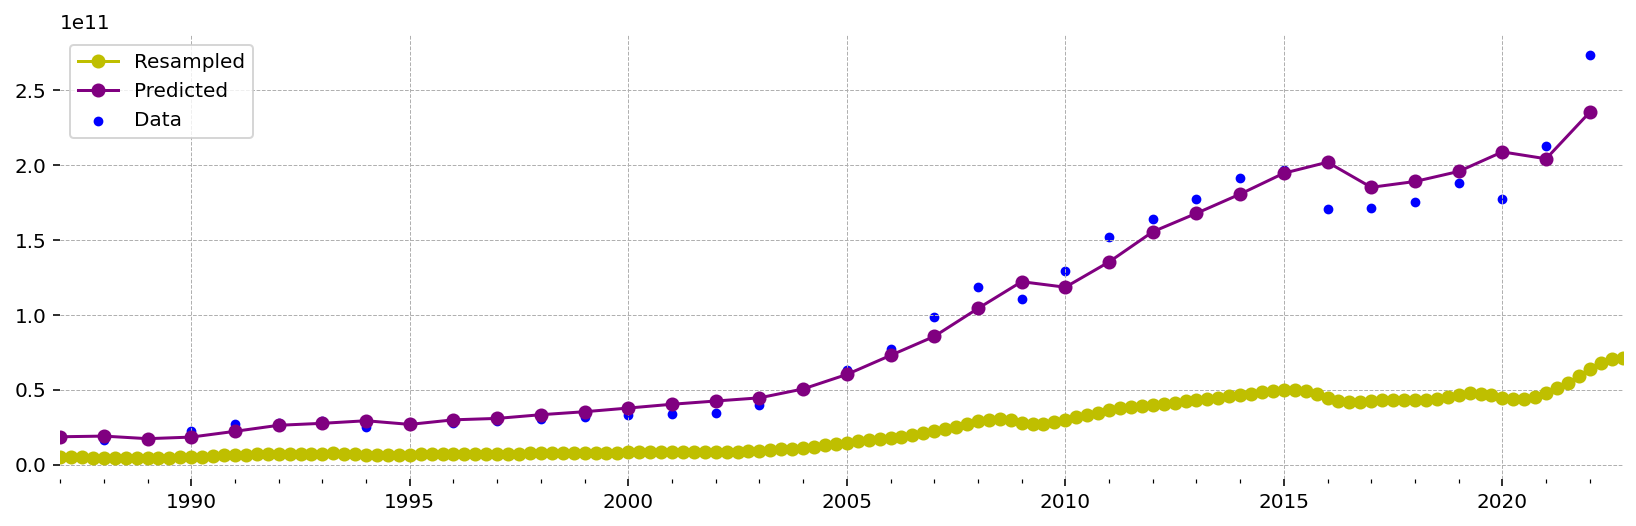

In [86]:
#Make predictions for quarterly data
#quarterly_periods = [1, 2, 3, 4] // elia what did you use here? Cant find anything in the original code and i dont see quarterly periods defined anywhere else
quarterly_periods = I_resample.index
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([I_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
#I_predict.reset_index(inplace=True)
#I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
I_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(I_quarterly.index, I_quarterly.values, s=15, c='b', label='Data')
ax.legend()
plt.show()


We can see how much closer we are to the original data points. SO we are gonna keep the results of this in our data set.

In [87]:

I_predict.info()
#Drop the number in the column row and also drop 'I' column
I_predict.drop(columns='I', inplace=True)
#Rename the dataset to better fit our current notation
I_predict.columns = ['I']


I_predict.info()
I_predict.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1987-01-01 to 2022-10-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       288 non-null    float64
 1   I       0 non-null      float64
dtypes: float64(2)
memory usage: 6.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1987-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I       288 non-null    float64
dtypes: float64(1)
memory usage: 4.5 KB


,I
1987-01-01,4.932778e+09
1987-01-01,4.932778e+09
1987-04-01,4.932778e+09
1987-04-01,4.873156e+09
1987-07-01,4.753910e+09


In [88]:
#### JUST A TEST VERSION OF THE MERGE

# Drop the 'I' column from final_df and join with I_predict
I_predict = I_predict[~I_predict.index.duplicated(keep='first')]

I_predict.info()
I_predict.head()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1987-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   I       144 non-null    float64
dtypes: float64(1)
memory usage: 2.2 KB


,I
1987-01-01,4.932778e+09
1987-04-01,4.932778e+09
1987-07-01,4.753910e+09
1987-10-01,4.575042e+09
1988-01-01,4.336551e+09


In [89]:
final_df.info()
final_df_quarterly = final_df
final_df_quarterly = final_df_quarterly.drop(columns=['I']).join(I_predict)

# If you want to rename 'Predicted_I' back to 'I', you can do:
#df_final.rename(columns={'Predicted_I': 'I'}, inplace=True)


#final_df = df_final.drop(columns=['I'])
#final_df = df_final.merge(I_predict.set_index('Date'), left_index=True, right_index=True)

final_df.info()
final_df_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y         55 non-null     float64
 1   Y_yearly  36 non-null     float64
 2   I         36 non-null     float64
 3   C         55 non-null     float64
 4   TB        36 non-null     float64
 5   rt        67 non-null     float64
 6   w         27 non-null     float64
 7   N         27 non-null     float64
 8   Rt        27 non-null     float64
 9   K         33 non-null     float64
 10  CA        36 non-null     float64
 11  CPI       36 non-null     float64
 12  Ex_Rate   442 non-null    float64
 13  Oil       9317 non-null   float64
dtypes: float64(14)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9775 entries, 1987-01-01 to 2023-12-26
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Y 

In [90]:
print(final_df_quarterly['I'])
print(final_df_quarterly.head())
final_df_quarterly.info()
print(final_df_quarterly.index)
print(final_df_quarterly.columns)

DATE
1987-01-01    4.932778e+09
1987-01-02             NaN
1987-01-05             NaN
1987-01-06             NaN
1987-01-07             NaN
                  ...     
2023-12-20             NaN
2023-12-21             NaN
2023-12-22             NaN
2023-12-25             NaN
2023-12-26             NaN
Name: I, Length: 9775, dtype: float64
             Y      Y_yearly   C            TB  rt   w   N  Rt           K  \
DATE                                                                         
1987-01-01 NaN  8.569594e+10 NaN -1.138400e+10 NaN NaN NaN NaN  1217826.25   
1987-01-02 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-05 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-06 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-07 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   

                   CA       CPI  Ex_Rate    Oil             I  
DATE                                             

## Resampling of Oil 

In [91]:
#create a disaggregate version of I to derive quarterly data from a yearly dataframe
Oil_resample = final_df['Oil'].copy()
Oil_resample.head()

DATE
1987-01-01      NaN
1987-01-02    18.13
1987-01-05    17.98
1987-01-06    18.21
1987-01-07    18.28
Name: Oil, dtype: float64

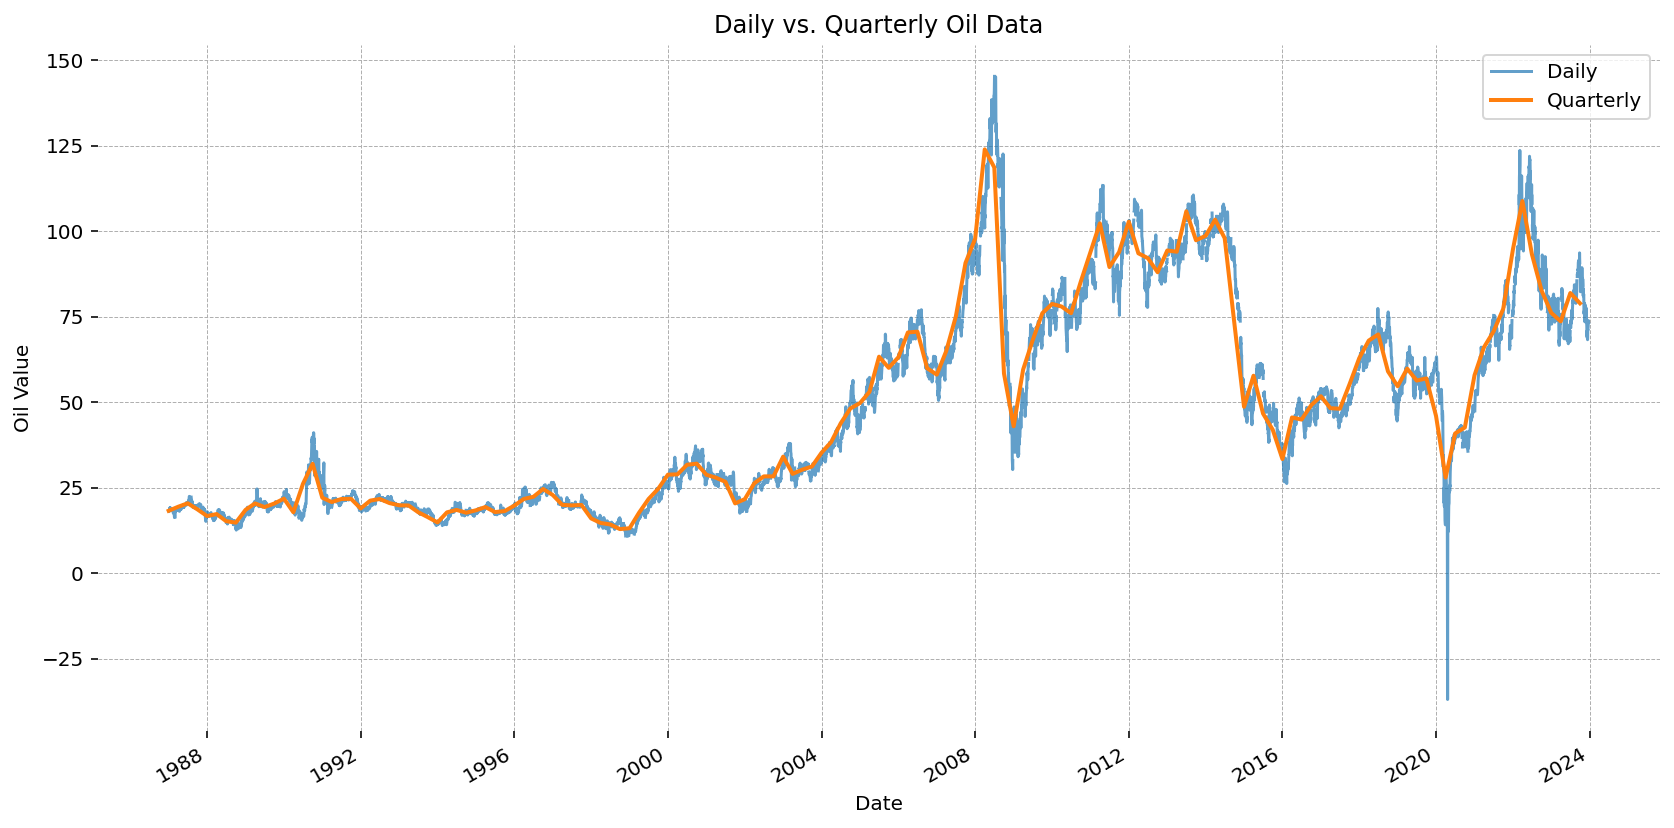

In [96]:
Oil_resample_filled = Oil_resample.ffill()
Oil_quarterly = Oil_resample_filled.resample('QS', closed='left', label='left').mean() # so it actually starts at the first. otherwise everything will be messed up again
plt.figure(figsize=(14, 7))

# Plot daily data
Oil_resample.plot(label='Daily', alpha=0.7)

# Plot quarterly data
Oil_quarterly.plot(label='Quarterly', lw=2)

plt.title('Daily vs. Quarterly Oil Data')
plt.xlabel('Date')
plt.ylabel('Oil Value')
plt.legend()
plt.grid(True)
plt.show()

In [97]:
Oil_quarterly.info()
Oil_quarterly.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Oil
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


DATE
1987-01-01    18.228923
1987-04-01    19.397538
1987-07-01    20.425224
1987-10-01    18.644030
1988-01-01    16.685846
Freq: QS-JAN, Name: Oil, dtype: float64

In [98]:
Oil_quarterly.info()
#Drop the number in the column row and also drop 'I' column
Oil_quarterly_frame = Oil_quarterly.to_frame()

Oil_quarterly_frame.columns = ['Oil']


Oil_quarterly_frame.info()
Oil_quarterly_frame.head()


<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Oil
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Oil     148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


,Oil
DATE,
1987-01-01,18.228923
1987-04-01,19.397538
1987-07-01,20.425224
1987-10-01,18.644030
1988-01-01,16.685846


In [99]:
### last step merge oil back to frame
# Add it back into the data, dropping the old data
final_df_quarterly = final_df_quarterly.drop(columns=['Oil']).join(Oil_quarterly_frame)

In [100]:
### last step merge oil back to frame
print(final_df_quarterly['Oil'])
print(final_df_quarterly.head())
final_df_quarterly.info()
print(final_df_quarterly.index)
print(final_df_quarterly.columns)

DATE
1987-01-01    18.228923
1987-01-02          NaN
1987-01-05          NaN
1987-01-06          NaN
1987-01-07          NaN
                ...    
2023-12-20          NaN
2023-12-21          NaN
2023-12-22          NaN
2023-12-25          NaN
2023-12-26          NaN
Name: Oil, Length: 9775, dtype: float64
             Y      Y_yearly   C            TB  rt   w   N  Rt           K  \
DATE                                                                         
1987-01-01 NaN  8.569594e+10 NaN -1.138400e+10 NaN NaN NaN NaN  1217826.25   
1987-01-02 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-05 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-06 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-07 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   

                   CA       CPI  Ex_Rate             I        Oil  
DATE                                                               
1987-01-

## Resampling of Ex_Rate 

In [108]:
Ex_Rate_resample = final_df['Ex_Rate'].dropna().copy()
Ex_Rate_resample.head()
Ex_Rate_resample.index.inferred_freq

'MS'

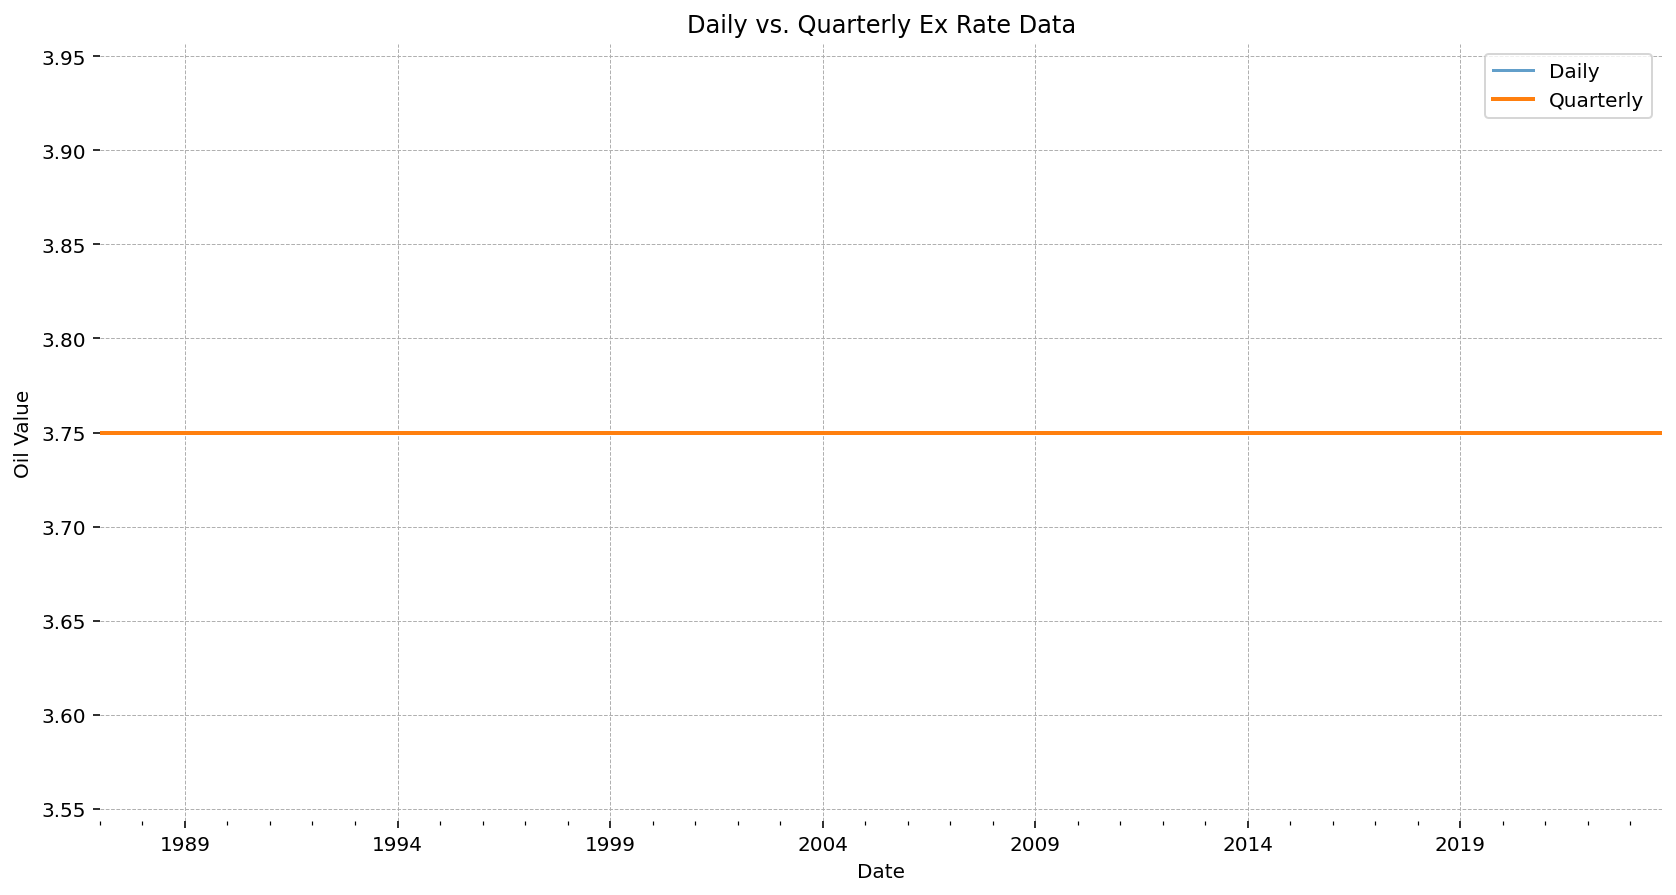

In [109]:
Ex_Rate_quarterly = Ex_Rate_resample.resample('QS', closed='left', label='left').mean() #doesnt really matter as everything equals 3.76
plt.figure(figsize=(14, 7))

# Plot daily data
Ex_Rate_resample.plot(label='Daily', alpha=0.7)

# Plot quarterly data
Ex_Rate_quarterly.plot(label='Quarterly', lw=2)

plt.title('Daily vs. Quarterly Ex Rate Data')
plt.xlabel('Date')
plt.ylabel('Oil Value')
plt.legend()
plt.grid(True)
plt.show()

In [111]:
Ex_Rate_quarterly.info()
Ex_Rate_quarterly.head()

<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Ex_Rate
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 2.3 KB


DATE
1987-01-01    3.75
1987-04-01    3.75
1987-07-01    3.75
1987-10-01    3.75
1988-01-01    3.75
Freq: QS-JAN, Name: Ex_Rate, dtype: float64

In [115]:

Ex_Rate_quarterly.info()
#Drop the number in the column row and also drop 'I' column
Ex_Rate_quarterly_Frame = Ex_Rate_quarterly.to_frame()

Ex_Rate_quarterly_Frame.columns = ['Ex_rate']


Ex_Rate_quarterly_Frame.info()
Ex_Rate_quarterly_Frame.head()


<class 'pandas.core.series.Series'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Series name: Ex_Rate
Non-Null Count  Dtype  
--------------  -----  
148 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 148 entries, 1987-01-01 to 2023-10-01
Freq: QS-JAN
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  148 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


,Ex_rate
DATE,
1987-01-01,3.75
1987-04-01,3.75
1987-07-01,3.75
1987-10-01,3.75
1988-01-01,3.75


In [117]:
print(final_df_quarterly.head())


             Y      Y_yearly   C            TB  rt   w   N  Rt           K  \
DATE                                                                         
1987-01-01 NaN  8.569594e+10 NaN -1.138400e+10 NaN NaN NaN NaN  1217826.25   
1987-01-02 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-05 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-06 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-07 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   

                   CA       CPI             I        Oil  Ex_rate  
DATE                                                               
1987-01-01 -11.389104 -1.547117  4.932778e+09  18.228923     3.75  
1987-01-02        NaN       NaN           NaN        NaN      NaN  
1987-01-05        NaN       NaN           NaN        NaN      NaN  
1987-01-06        NaN       NaN           NaN        NaN      NaN  
1987-01-07        NaN       NaN           NaN

In [120]:
### last step merge oil back to frame
# Add it back into the data, dropping the old data
final_df_quarterly = final_df_quarterly.drop(columns=['Ex_rate']).join(Ex_Rate_quarterly_Frame)
print(final_df_quarterly['Ex_rate'])
print(final_df_quarterly.head())
final_df_quarterly.info()
print(final_df_quarterly.index)
print(final_df_quarterly.columns)

DATE
1987-01-01    3.75
1987-01-02     NaN
1987-01-05     NaN
1987-01-06     NaN
1987-01-07     NaN
              ... 
2023-12-20     NaN
2023-12-21     NaN
2023-12-22     NaN
2023-12-25     NaN
2023-12-26     NaN
Name: Ex_rate, Length: 9775, dtype: float64
             Y      Y_yearly   C            TB  rt   w   N  Rt           K  \
DATE                                                                         
1987-01-01 NaN  8.569594e+10 NaN -1.138400e+10 NaN NaN NaN NaN  1217826.25   
1987-01-02 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-05 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-06 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   
1987-01-07 NaN           NaN NaN           NaN NaN NaN NaN NaN         NaN   

                   CA       CPI             I        Oil  Ex_rate  
DATE                                                               
1987-01-01 -11.389104 -1.547117  4.932778e+09  18.228923   

## Resampling of TB 

C:\Users\mauri\AppData\Local\Temp\ipykernel_36304\1248248715.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


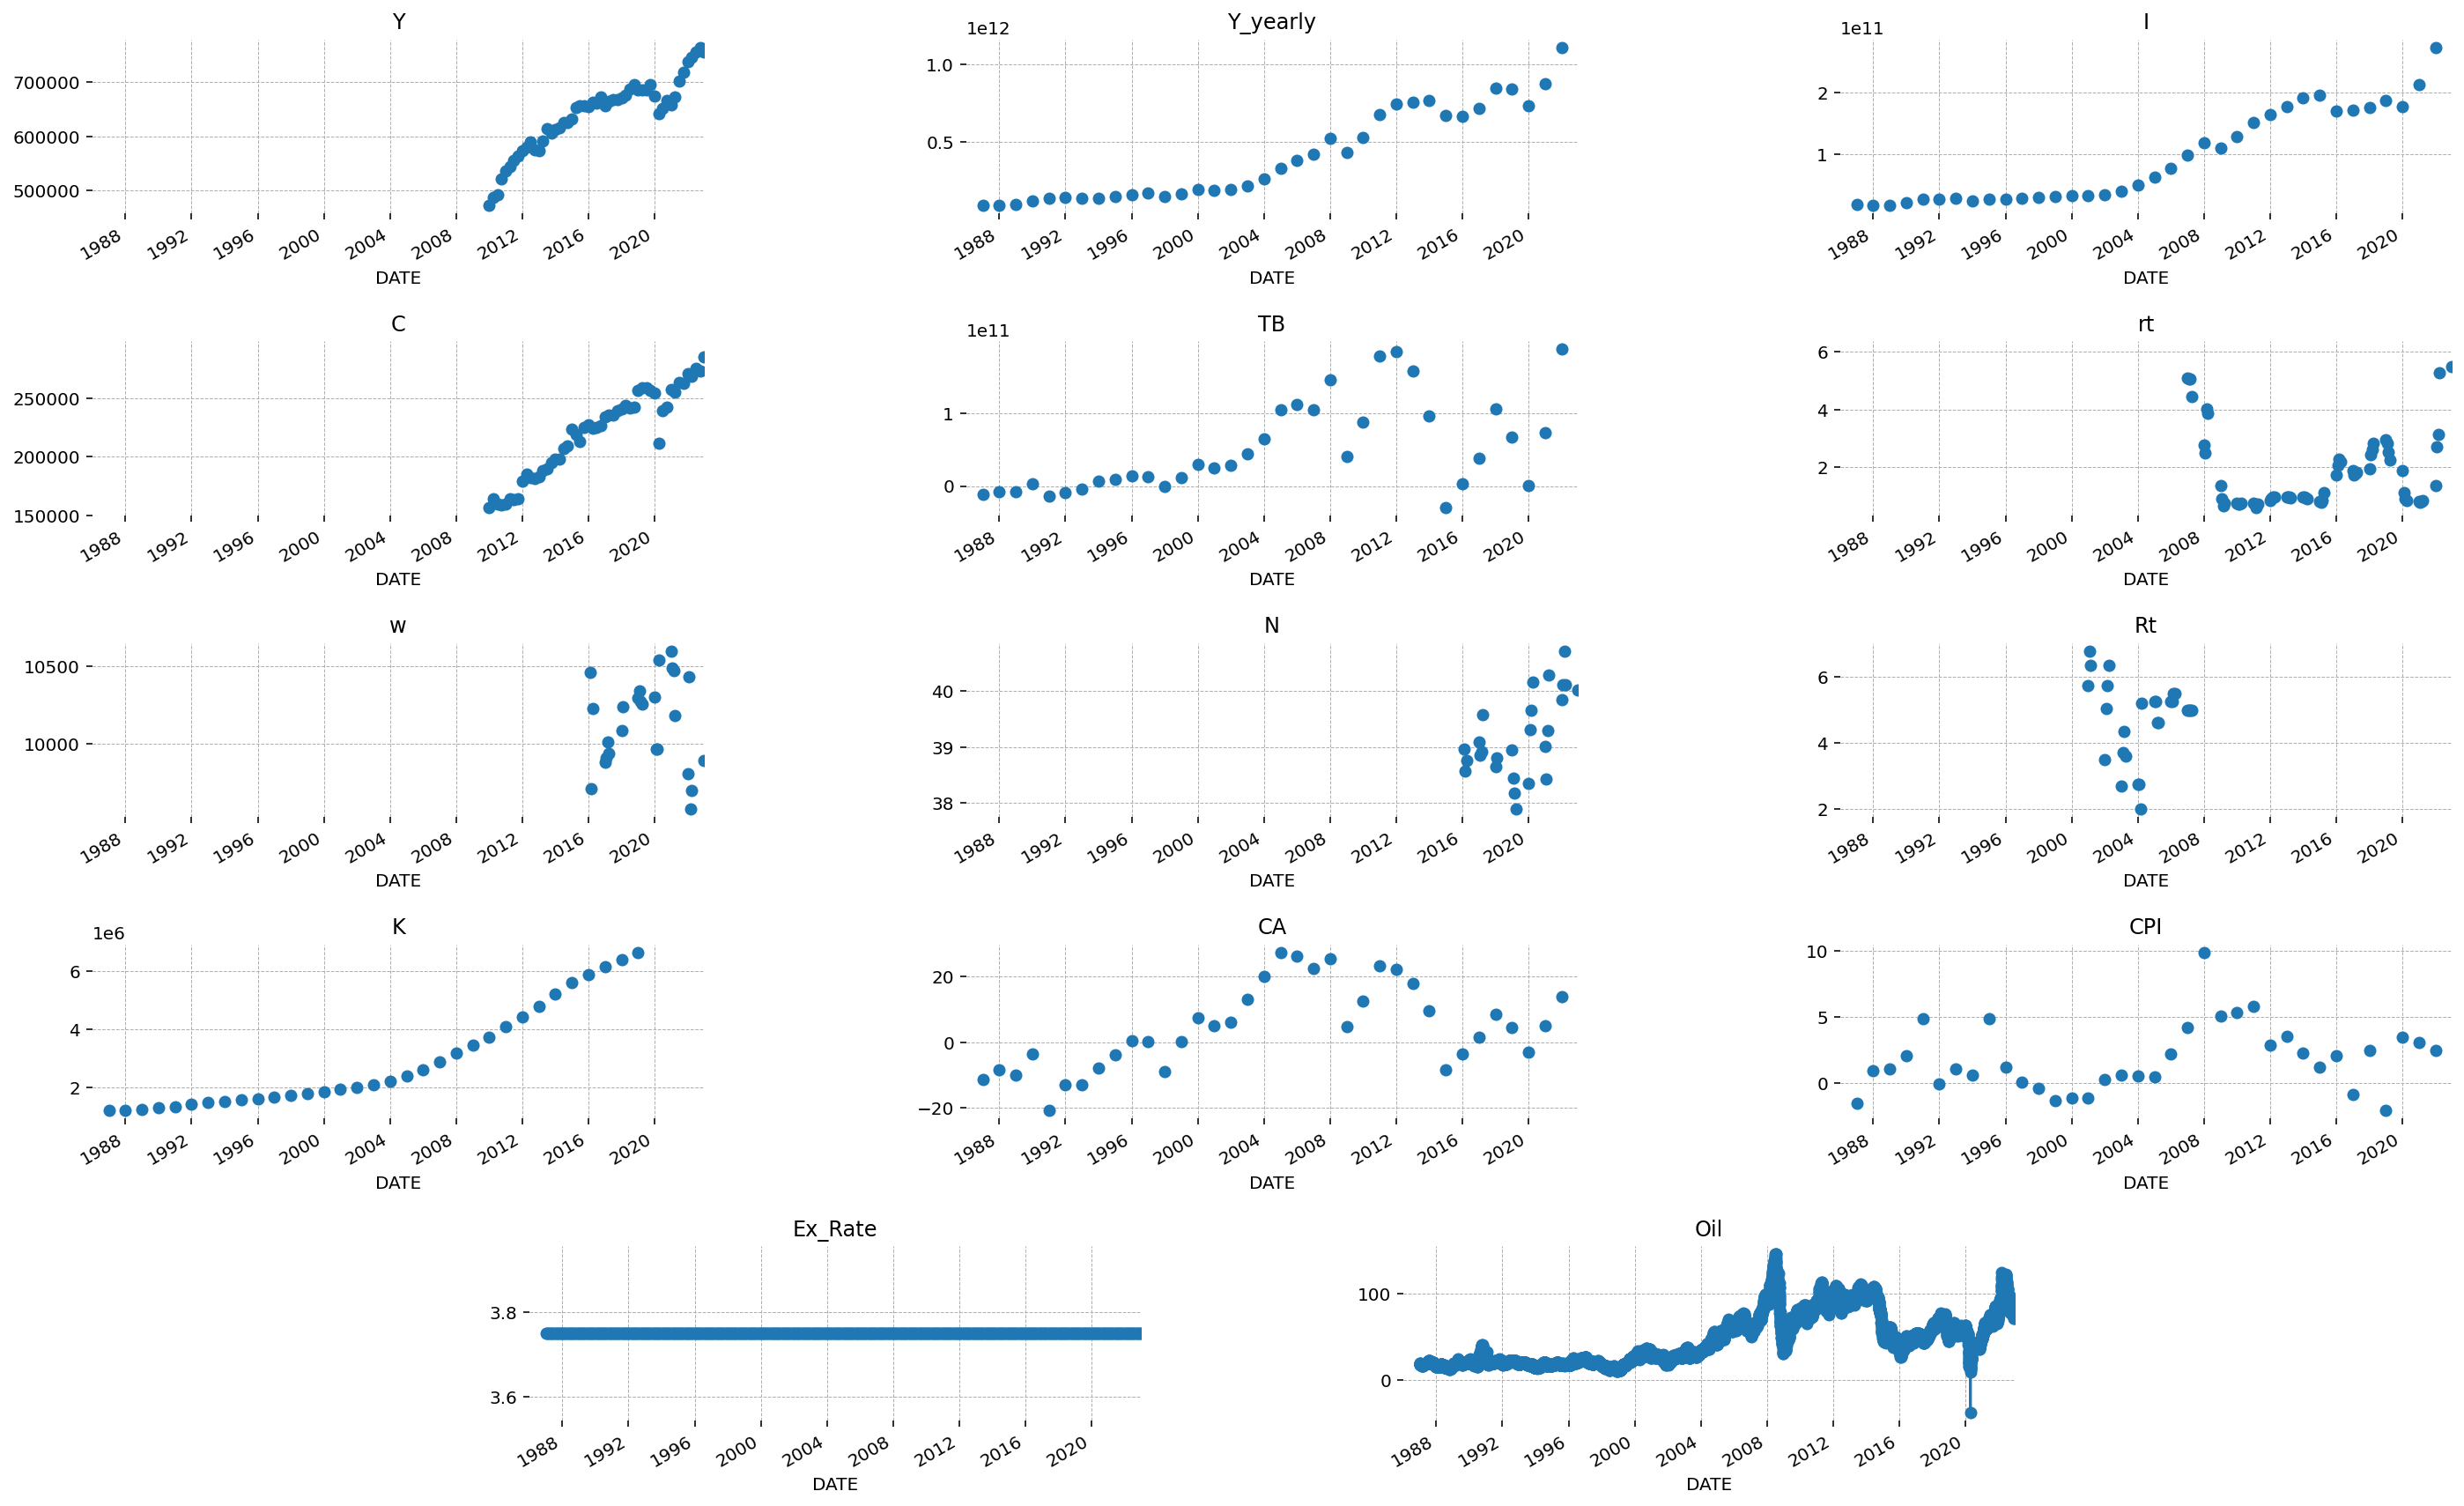

In [121]:
def plot_df(final_df, **plot_kwargs):
    fig = plt.figure(figsize=(24, 16), dpi=144)  # Increased figure size
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=final_df.shape[1])

    # Adjusting the layout for better spacing
    gs.update(hspace=5.5, wspace=1.5)  

    for loc, var in zip(plot_locs, final_df):
        axis = fig.add_subplot(gs[loc])
        final_df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

        # Set x-axis limits
        axis.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2022-12-31'))

    plt.tight_layout()
    plt.show()

plot_df(final_df, marker='o')


## <span style="color:red">I HAVE WORKED UNTIL HERE</span> ## 


In [ ]:
#Testing if all work properly now
def plot_df(final_df, **plot_kwargs):
    fig = plt.figure(figsize=(24, 16), dpi=144)  # Increased figure size
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=final_df.shape[1])

    # Adjusting the layout for better spacing
    gs.update(hspace=5.5, wspace=1.5)  

    for loc, var in zip(plot_locs, final_df):
        axis = fig.add_subplot(gs[loc])
        final_df[var].plot(ax=axis, **plot_kwargs)
        axis.set_title(var)

        # Set x-axis limits
        axis.set_xlim(pd.Timestamp('1986-01-01'), pd.Timestamp('2022-12-31'))

    plt.tight_layout()
    plt.show()

plot_df(final_df, marker='o')


#### 1) <u>Yt=Real Gross Domestic Product<u/>

| Step | Variable  | Adjustment from Annual to Quarterly Data? | Expansion from time horizon forward/Backward? |
|------|-----------|------------|-----------------------|
| 1    | Y         | No                                             | Yes                                                     |
| 2    | Y_yearly  | No                                             | No                                                     |
| 3    | I         | Yes                                             | No                                                     |
| 4    | C         | Yes                                             | Yes                                                     |
| 5    | TB        | Yes                                             | No                                                     |
| 6    | rt        | No                                             | Yes                                                     |
| 7    | w         | No                                             | Yes                                                     |
| 8    | Rt        | No                                            | Yes                                                     |
| 9    | K         | No                                             | Yes                                                     |
| 10   | CA        | Yes                                             | Yes                                                     |
| 11   | CPI       | Yes                                             | Yes                                                     |
| 12   | Ex_Rate   | No                                             | Yes                                                     |
| 13   | Oil       | No                                             | Yes                                                     |


##### 1.1) Reshaping & Seasonality correction

In [ ]:
#Check the format of the data so make sure we have a float variable
final_df.info()

##### FRED already provides seasonally adjutsted data for Saudi Arabia's GDP. No further adjustment for seasonality needed. 

In [ ]:
#Create an index using our Date column
df1.set_index('Date', inplace=True)
df1.head()

##### 1.3) Log adjustment (stationary test)

In [ ]:
#1.3.1 Importing Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import gatspy as gp


In [ ]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df1['Y'])

##### The Augmented Dickey-Fuller test indicates potential stationarity with the constant term alone, as its test statistic surpasses the 1% critical value. Consequently, with a P-value of 0.004 for the constant term, we reject the null hypothesis at the 1% significance level. 

##### 1.4) Currency conversion

In [ ]:
#Import necessary libraries
import pandas as pd
import pandas_datareader as pdr
#Import data for US dollar-Saudi Riyal Exchange rate
series_code = 'SAUCCUSMA02STM'
us_saudi = pdr.get_data_fred(series_code)
from pandas_datareader.fred import FredReader
data_cur = FredReader(symbols=['SAUCCUSMA02STM'], start='1960', end=None).read()
data_cur.to_csv('SA_currency_exch.csv')
data_cur = pd.read_csv('SA_currency_exch.csv', parse_dates=['DATE'])
#Rename the columns
#data_cur.columns = ['Date', 'ExRate']
data_cur.to_csv('SA_currency_exch.csv', index=False)
data_cur.rename(columns={'DATE': 'Date', 'SAUCCUSMA02STM': 'Ex_Rate'}, inplace=True)
#Rename columns
#data_cur = us_saudi.rename(columns={'SAUCCUSMA02STM': 'us_saudi_ER'})
data_cur.info

In [ ]:
#The actual time serie for US dollars-Riyal exchange rate has a monthly frequently, we want it quarterly 
us_saudi_q = us_saudi.resample('Q').mean()
us_saudi_q.reset_index(inplace=True)
print(us_saudi_q.head())

In [ ]:
#Merge the first two DataFrames on the 'Date' column
df1m= pd.merge(data_cur, df1, on='Date')
#Eventually convert date to datetime format for proper plotting
df1m.head()

##### As regards Y (GDP), here, the currency conversion is not a necessary step to be undertaken given that FRED already provides data expressed in USD dollars. However, we hold that it is paramount to have this step already set to be run from the very beginning in case we may need it for future variables' adjustments.   

In [ ]:
#df1 currency conversion
#df1_cur['YT_USD'] = df1_cur['Y']/df1_cur['Ex_Rate']
#df1_cur

#renamed it to data cur
#df1 currency conversion
df1m['YT_USD'] = df1m['Y'] / df1m['Ex_Rate']
df1m

#### 2) <u>C=Real Private Sector Final Consumption Expenditure<u/>

##### 2.1) Data reshaping 

In [ ]:
#Importing Real Private Sector Final Consumption Expenditure 
#Data is not seasonaly adjusted yet
data = FredReader(symbols=['NCPRNSAXDCSAQ'], start='2010', end=None).read()
data.to_csv('SA_real_private_consumption_not_adjusted.csv')
#Read the CSV file and parse 'DATE' as datetime
df2 = pd.read_csv('SA_real_private_consumption_not_adjusted.csv', parse_dates=['DATE'])
#Save for merging later 
df2.to_csv('SA_real_private_consumption_not_adjusted.csv', index=False)
#Rename the columns
df2.columns = ['Date', 'C']
#Convert date on datetime format for proper plotting
df2['Date'] = pd.to_datetime(df2['Date'])
df2.head()

##### 2.2) Data format

In [ ]:

#Plot the dataframe to displat C over time 
import pandas as pd
import matplotlib.pyplot as plt
plt.plot(final_df['DATE'], final_df['C'], marker='o', linestyle='-', color='purple')
plt.title('C variation over time')
plt.xlabel('DATE')
plt.ylabel('C')
plt.grid(True)
plt.show()

##### 2.3) Log adjustment (Stationarity test)

In [ ]:
#Plot the log transformed difference 
df2.C.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of C over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of C
df2['log_C'] = df2['C'].map(np.log)
df2['diff_log_C'] = df2['log_C'].diff()
#Include the 'Date' column from df2
d_log_C = df2[['Date']].copy()
d_log_C['diff_log_C'] = df2['diff_log_C']
d_log_C.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df2['C'])

##### After running the ADF test we find that both the constant and trend are statistically significant. Further, the statistical value for the constand and trend model is lower than the critical value of -4.137. Therefore we reject the null hypothesis of a unit root, suggesting that the series is stationary. We do so at the 1% significance level.

##### 2.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_C['Quarter'] = d_log_C['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_C_pivot = d_log_C.pivot_table(index='Quarter', columns=d_log_C['Date'].dt.year, values='diff_log_C')
#Display the pivot table
d_C_pivot.head()

In [ ]:
d_C_pivot.plot(legend=False);

###### Results seem not completly random but neither completly non random. Not adjusting for seasonality. 

##### 2.5) Currency conversion

###### No currency conversion needed, since data are already provided in US dollar units. 

#### 2.6) Progressive merging 

In [ ]:
#Drop temporary columns
df2 = df2.drop('diff_log_C', axis=1)
#Merge step 1 merged dataset with df2
df2m= pd.merge(df1m, df2, on='Date')
df2m.head()

#### 3) <u>I=Gross Fixed Capital Formation<u/>

#### 3.1) Data reshaping 

In [ ]:
#Importing Gross Fixed Capital Formation NE.GDI.FTOT.CD Annual
import pandas as pd
import pandas_datareader.wb as wb
#Define the World Bank indicator code for "Gross Fixed Capital Formation"
indicator_code = 'NE.GDI.FTOT.CD'
#Define countries and time period
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'
#Fetch World Bank data using the pandas_datareader library
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)
#Reset index to make 'Date' a column
world_bank_data.reset_index(inplace=True)
#Drop 'country' column
world_bank_data.drop('country', axis=1, inplace=True)
#Rename 'year' column to 'Date'
world_bank_data.rename(columns={'year': 'Date', 'NE.GDI.FTOT.CD': 'I'}, inplace=True)
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])  # Fix: use 'year' instead of 'Date'
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['I'] = world_bank_data['I'] / 1_000_000
#Sort data so frequency runs correct 
df3 = world_bank_data.copy().set_index('Date').sort_index()
df3.head()
#Date is already in datetime format, no further actions needed 

#### 3.2) Quarters' value prediction

In [ ]:
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')

In [ ]:
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')
#Resample data to fit quartelry framework: create quarter data from a yearly frequency dataframe
#Plot the resampled data and original data
df3_resample.plot(label= 'Resampled', marker='o', color= 'y')
df3.I.resample('QS').asfreq().plot(label= 'Data', marker='o', color= 'b')
plt.legend()
plt.show()

In [ ]:
#Taking a look at the NA
quarterly_I = df3.I.mul(0.25).resample('QS').asfreq()
quarterly_I.tail()

In [ ]:
%%capture
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(quarterly_I, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)

In [ ]:
res.summary()

In [ ]:


res.summary()
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['I'] = world_bank_data['I'] / 1_000_000
#Sort data so frequency runs correct 
df3 = world_bank_data.copy().set_index('Date').sort_index()
df3.head()
#Date is already in datetime format, no further actions needed 
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')
%%capture
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(quarterly_I, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)
#Plot both our predicted trend on a quarterly scale and real data
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()
#Make predictions for quarterly data
quarterly_periods = ['2010-01-01', '2022-10-01'] # define periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([df3_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.index = pd.to_datetime(I_predict.index)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
I_predict.reset_index(inplace=True)
I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df3_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()


plt.show()

In [ ]:


res.summary()
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['I'] = world_bank_data['I'] / 1_000_000
#Sort data so frequency runs correct 
df3 = world_bank_data.copy().set_index('Date').sort_index()
df3.head()
#Date is already in datetime format, no further actions needed 
from tsdisagg import disaggregate_series
#create a disaggregate version of df3 to derive quarterly data from a yearly dataframe
df3_resample= disaggregate_series(df3.I, target_freq='QS', agg_func='sum')
%%capture
import statsmodels.api as sm
#We set the trend to 'ctt' which means quadratic trend, since this data seems to increase exponentially.
mod = sm.tsa.SARIMAX(quarterly_I, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)
#Plot both our predicted trend on a quarterly scale and real data
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()
#Make predictions for quarterly data
quarterly_periods = ['2010-01-01', '2022-10-01'] # define periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([df3_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.index = pd.to_datetime(I_predict.index)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
I_predict.reset_index(inplace=True)
I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df3_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()


plt.show()


#############################



#Make predictions for quarterly data
quarterly_periods = ['2010-01-01', '2022-10-01'] # define periods
predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
I_predict = pd.concat([df3_resample, pd.DataFrame(predicted_data, columns=['I'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
I_predict.index = pd.to_datetime(I_predict.index)
I_predict.sort_index(inplace=True)
#Reset index and rename to Date
I_predict.reset_index(inplace=True)
I_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
I_predict.ffill(inplace=True)
print(I_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df3_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()

################################

#Reset index and rename to match your requirements
#combined_data_I.reset_index(inplace=True)
#Drop the number in the column row and also drop 'I' column
I_predict.rename(columns={0: 'I_pred'}, inplace=True)
I_predict.drop(columns='I', axis=1, inplace=True)
#Rename our target column 
I_predict = I_predict.rename(columns={'I_pred': 'I'})
#Rename the dataset to better fit our current notation
df3p = I_predict
df3p.head()

In [ ]:
#Reset index and rename to match your requirements
#combined_data_I.reset_index(inplace=True)
#Drop the number in the column row and also drop 'I' column
I_predict.rename(columns={0: 'I_pred'}, inplace=True)
I_predict.drop(columns='I', axis=1, inplace=True)
#Rename our target column 
I_predict = I_predict.rename(columns={'I_pred': 'I'})
#Rename the dataset to better fit our current notation
df3p = I_predict
df3p.head()

##### Results seem to be reasonable according to our yearly original data from df3 (!e+11--->e+10, xpredicted roughly 1/4 (quarter) of x).

#### 3.3) Log adjustment (Stationarity test)

In [ ]:
#Plot the log transformed difference 
df3p.I.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of I over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of I
df3p['log_I'] = df3p['I'].map(np.log)
df3p['diff_log_I'] = df3p['log_I'].diff()
#Include the 'Date' column from df3p
d_log_I = df3p[['Date']].copy()
d_log_I['diff_log_I'] = df3p['diff_log_I']
d_log_I.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df3p['I'])

##### After conducting the ADF test, the results indicate non-stationarity for all model specifications. The highest T-statistic is 1.630, which is well below the critical value of -3.495 at the 1% significance level. Hence, we fail to reject the null hypothesis of a unit root, confirming that the series is non-stationary

##### => So we need to adjust dont we?

#### 3.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_I['Quarter'] = d_log_I['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_I_pivot = d_log_I.pivot_table(index='Quarter', columns=d_log_I['Date'].dt.year, values='diff_log_I')
#Display the pivot table
d_I_pivot.head()

In [ ]:
d_I_pivot.plot(legend=False);

###### Results highly differ from typical seasonal trends. Values seem not following recursive cycles. Not adjusting for seasonality. 

##### 3.5) Currency conversion

###### No currency conversion needed, since data are already provided in US dollar units. 

#### 3.6) Progressive merging 

In [ ]:
#Drop temporary columns
df3p = df3p.drop('diff_log_I', axis=1)
#merge step 2 merged dataset with df3
df3m= pd.merge(df2m, df3p, on='Date')
df3m.head()

#### 4) <u>TB=Trade Balance trade in goods and services<u/>

#### 4.1) Data reshaping 

In [ ]:
import pandas as pd
import pandas_datareader.wb as wb
#Define World Bank indicator code for Trade Balance
indicator_code = 'BN.GSR.GNFS.CD'
#Define the countries and time period
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'
#Fetch World Bank data using pandas_datareader
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)
#Reset index to build Date column
world_bank_data.reset_index(inplace=True)
#Drop country
world_bank_data.drop('country', axis=1, inplace=True)
#Rename year to Date
world_bank_data.rename(columns={'year': 'Date', 'BN.GSR.GNFS.CD': 'TB'}, inplace=True)
#Convert date on datetime format for proper plotting
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])
#Data are in USD, but for a better visualization and scale omogeneity, we want them in millions USD 
world_bank_data['TB'] = world_bank_data['TB'] / 1_000_000
#Sort the DataFrame by the 'Date' column in descending order
world_bank_data = world_bank_data.sort_values(by='Date', ascending=True)
df4 = world_bank_data.copy()
df4.info()
df4.head()

#### 4.2) Quarters' value prediction

In [ ]:
from tsdisagg import disaggregate_series
#create a disaggregate version of df4 to derive quarterly data from a yearly dataframe
df4.set_index('Date', inplace=True)
df4_resample= disaggregate_series(df4.TB, target_freq='QS', agg_func='sum')

In [ ]:
#Resample data to fit quartelry framework: create quarter data from a yearly frequency dataframe
#Plot the resampled data and original data
df4_resample.plot(label= 'Resampled', marker='o', color= 'y')
df4.TB.resample('QS').asfreq().plot(label= 'Data', marker='o', color= 'b')
plt.legend()
plt.show()

In [ ]:
import statsmodels.api as sm
#Taking a look at the NA
quarterly_TB = df4.TB.mul(0.25).resample('QS').asfreq()
quarterly_TB.tail()

In [ ]:
import statsmodels.api as sm
#We set the trend to 'ct' which means linear trend, since data seem not giving further specific hints for choosing other hypothetical interation. 
mod = sm.tsa.SARIMAX(quarterly_TB, order=(1, 0, 0), trend='ctt')
res = mod.fit(method='nm', maxiter=10_000)

In [ ]:
res.summary()

In [ ]:
#Plot both our predicted trend on a quarterly scale and real data
fig, ax = plt.subplots()
res.predict().plot(label='Predicted', ax=ax, c= 'purple')
ax.scatter(quarterly_TB.index, quarterly_TB.values, s=15, c='b', label='Data')
ax.legend()
plt.show()

In [ ]:
#Reset index and rename to match your requirements
#combined_data_I.reset_index(inplace=True)
#Drop the number in the column row and also drop 'I' column
TB_predict.rename(columns={0: 'TB_pred'}, inplace=True)
TB_predict.drop(columns='TB', axis=1, inplace=True)
#Rename our target column 
TB_predict = TB_predict.rename(columns={'TB_pred': 'TB'})
#Rename the dataset to better fit our current notation
df4p = TB_predict
df4p

In [ ]:
#Make predictions for quarterly data

predictions = res.get_prediction(start=quarterly_periods[0], end=quarterly_periods[-1])
predicted_data = predictions.predicted_mean
#Combine original quarterly data with predicted quarterly data
TB_predict = pd.concat([df4_resample, pd.DataFrame(predicted_data, columns=['TB'], index=quarterly_periods)])
#Sort the combined data by the index (Date)
TB_predict.index = pd.to_datetime(TB_predict.index) # added a time index @Elia
TB_predict.sort_index(inplace=True)
#Reset index and rename to Date
TB_predict.reset_index(inplace=True)
TB_predict.rename(columns={'index': 'Date'}, inplace=True)
#Forward-fill NAs
TB_predict.ffill(inplace=True)
print(TB_predict)
#Plot both our predicted trend on a quarterly scale and resampled data
fig, ax = plt.subplots()
df4_resample.plot(label= 'Resampled', marker='o', c= 'y')
res.predict().plot(label='Predicted', marker= 'o', ax=ax, c= 'purple')
ax.scatter(quarterly_I.index, quarterly_I.values, s=15, c='b', label='Data')
ax.legend()
plt.show()

##### Results seem again to be reasonable according to our yearly original data from df3 (!e+11--->e+10, xpredicted roughly 1/4 (quarter) of x).

##### The predicted numbers seem to be in line with our yearly data from df4. The older data from a few years back is roughly four times the predicted values, which is okay. But it's worth noting that after 2015, things differ, especially when the numbers go negative. So, while the model's doing a decent job, we might want to keep an eye on those recent predictions

#### 4.3) Log adjustment (Stationarity test)

In [ ]:
#Here we have something different from the previous variables, since, as we know from macro101, the value of a trade balance can be potentially be negative (Imp>Exp)
#Hence, we can takle these negative sign results as we are used to other variables, since we may have "gaps" in our plot 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#To deal with negative values, we can just easily add an enough small constant to the whole dataframe without causing any bias to the analysis
#As constant we use a fraction of the minimum value of TB (based on XYZ idea)
min_value = df4p['TB'].min()
constant = abs(0.1 * min_value)
#Custom log transformation function from the original that we have previously used 
def safe_log(x):
    return np.log(x + constant) if x > 0 else np.nan
#Apply the custom log transformation to each value of TB
log_transformed = df4p['TB'].apply(safe_log).diff()
#Interpolate missing values (the ones that otherwise would create gaps and non-continuity in our graph)
log_transformed.interpolate(inplace=True)
#Plot the log-transformed differences
log_transformed.plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of TB over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of TB
df4p['log_TB'] = df4p['TB'].map(np.log)
df4p['diff_log_TB'] = df4p['log_TB'].diff()
#Include the 'Date' column from df4p
d_log_TB = df4p[['Date']].copy()
d_log_TB['diff_log_TB'] = df4p['diff_log_TB']
d_log_TB.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df4p['TB'])

#### After the ADF test, it seems evident that our data exhibits non-stationarity for all model configurations. The T-statistic of -1.740, while not extreme, remains above the critical value of -4.148 at the 1% significance level. This implies that a unit root might still be present, indicating the data's non-stationary behavior.### 
=> This hints at the importance of further data adjustments to potentially achieve stationarity.

#### 4.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_TB['Quarter'] = d_log_TB['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_TB_pivot = d_log_TB.pivot_table(index='Quarter', columns=d_log_TB['Date'].dt.year, values='diff_log_TB')
#Display the pivot table
d_TB_pivot.head()

In [ ]:
d_TB_pivot.plot(legend=False);

###### Results highly differ again from typical seasonal trends. Values seem not following recursive cycles. Not adjusting for seasonality. 

##### 4.5) Currency conversion

###### No currency conversion needed, since data are already provided in US dollar units. 

#### 4.6) Progressive merging 

In [ ]:
#Drop temporary columns
df4p = df4p.drop('diff_log_TB', axis=1)
#merge step 2 merged dataset with df3
df4m= pd.merge(df3m, df4p, on='Date')
df4m.head()

#### 5) <u>N=Average Hours of Work for Employed Persons<u/>

#### 5.1) Data reshaping

In [ ]:
#Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Average Hours of Work for Employed Persons
N_data = {
    '2016 / Q2': [38.96775504],
    '2016 / Q3': [38.57034481],
    '2016 / Q4': [38.75315665],
    '2017 / Q1': [39.09336699],
    '2017 / Q2': [38.85986074],
    '2017 / Q3': [38.9159003],
    '2017 / Q4': [39.58174661],
    '2018 / Q1': [38.64750733],
    '2018 / Q2': [38.80551713],
    '2019 / Q1': [38.94281089],
    '2019 / Q2': [38.43955095],
    '2019 / Q3': [38.17616634],
    '2019 / Q4': [37.88810263],
    '2020 / Q1': [38.35162171],
    '2020 / Q2': [39.31892759],
    '2020 / Q3': [39.65375889],
    '2020 / Q4': [40.16204173],
    '2021 / Q1': [39.01231081],
    '2021 / Q2': [38.43177217],
    '2021 / Q3': [39.30209818],
    '2021 / Q4': [40.29776716],
    '2022 / Q1': [39.84260952],
    '2022 / Q2': [40.12209799],
    '2022 / Q3': [40.72582419],
    '2022 / Q4': [40.11837913],
    '2023 / Q1': [40.01679873],
    '2023 / Q2': [40.35208325]
}
#Create a dataframe from the table
df5 = pd.DataFrame(N_data)
#In this structure, we have values for Nt alligned on single row, we prefer a column
df5 = df5.transpose()
#Rename the columns to fit the variable in question
df5.columns = ['N']
#Convert the index to datetime format with format specification
df5.index = pd.to_datetime(df5.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))
df5.index.name = 'Date'
df5.head()

#### 5.2) Data format & General overview

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#Set the display format for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)
#Summary statistics
summary_stats = df5.describe()
#min and max values
min_values = df5.min()
max_values = df5.max()
#Display the summary statistics, min, and max values
print("Summary Statistics:")
print(summary_stats)
print("\nMin Values:")
print(min_values)
print("\nMax Values:")
print(max_values)
#Histogram
plt.figure(figsize=(10, 6))
plt.hist(df5['N'], bins=10, color='purple', edgecolor='white')
plt.title('Distribution of N')
plt.xlabel('N')
plt.ylabel('Frequency')
plt.show()
#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df5.index, df5['N'], color='b')
plt.title('Scatter Plot of N over time')
plt.xlabel('Date')
plt.ylabel('N')
plt.show()

#### 5.3) Missing observations' prediction

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
#Since data are available only up to 2016, we do want to predict possible past trends to deduce those missing observations we have. 
df5p = pd.DataFrame()
#Loop through quarters from 2010-01-01 to 2016-12-01
for year in range(2010, 2017):
    for quarter in range(1, 5):
#Predict for the current quarter
        X_pred = np.array([[year, quarter]])
        prediction = model.predict(X_pred)
#Once the forecast is created, append the prediction to the new DataFrame
        df5p = pd.concat([df5p, pd.DataFrame({
            'Date': [pd.to_datetime(f"{year}-{quarter*3 - 2:02d}-01")],
            'Prediction': [prediction[0]]
        })], ignore_index=True)
#Set the Date column as the index
df5p.set_index('Date', inplace=True)
#Rename the prediction column 
df5p.rename(columns={'Prediction': 'N'}, inplace=True)
df5p.head()

In [ ]:
import matplotlib.pyplot as plt
#Plot our both  predicted and real data  
plt.plot(df5.index, df5['N'], label='Data', marker='o', linestyle='-', color= 'y')
plt.plot(df5p.index, df5p['N'], label='Predicted', marker='o', linestyle='-', color='purple')
plt.xlabel('Date')
plt.ylabel('N')
plt.legend()
plt.show()

In [ ]:
#Now merge the two datasets, appending at the beginning of df5 the new dataframe, df5p, containing predictions on the timespan 2010-2016.
#We also want to give priority to real data in case of overlapping values, hence, we will prioritize to df5
df5pm= df5p.combine_first(df5)
#Drop not useful columns
df5pm.drop(columns=['Year', 'Quarter'], inplace=True)
df5pm.head()

#### 5.4) Log adjustment (Stationarity test)

In [ ]:
#Plot the log transformed difference 
df5pm.N.map(np.log).diff().plot(marker='o', linestyle='-', color='purple')
plt.title('Log-transformed differences of N over time')
plt.xlabel('Date')
plt.ylabel('Log-transformed difference')
plt.grid(True)
plt.show()

In [ ]:
#Take the log of N
import numpy as np
import pandas as pd
df5pm['log_N'] = np.log(df5pm['N'])
#Derive the difference log
df5pm['diff_log_N'] = df5pm['log_N'].diff()
#Include the 'Date' column from df5pm
d_log_N = df5pm[['diff_log_N']].copy()
d_log_N['Date'] = df5pm.index  # Assuming 'Date' is the index
d_log_N.info()

In [ ]:
#Run the Augmented Dickey-Fuller test  to see if we need to adjust our data using logs due to stationary/non-stationary (N0:non-stationarity) 
ADF_test_summary(df5['N'])

##### The ADF test results consistently suggest that our data is non-stationary across all model configurations. The T-statistics are not sufficiently low to reject the presence of a unit root, and the p-values are high, further supporting this conclusion.
#### 
=> Given these findings, it's crucial tods to transform or adjust the data to achieve stationarity before applying certain time series anales s.

#### 5.4) Seasonality correction

In [ ]:
#Extract quarter information
d_log_N['Quarter'] = d_log_N['Date'].dt.quarter
#Create a pivot table based on quarter and year
d_N_pivot = d_log_N.pivot_table(index='Quarter', columns=d_log_N['Date'].dt.year, values='diff_log_N')
#Display the pivot table
d_N_pivot.head()

In [ ]:
d_N_pivot.plot(legend=False);

###### (!!!!MUST BE CHECKED, THERE IS PROBABLY SOMETHING WRONG IN D_LOG_N!!!!!!!) Results seem not completly random but neither completly non random. Not adjusting for seasonality. 

#### 5.5) Progressive merging

In [ ]:
#Drop temporary columns
df5pm = df5pm.drop('diff_log_N', axis=1)
#merge step 2 merged dataset with df3
df5m= pd.merge(df4m, df5pm, on='Date')
df5m.head()

#### 6) <u>w=Average Monthly Wages for Paid Employees<u/>

#### 6.1) Data reshaping

In [ ]:
#Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Average Monthly Wages for Paid Employees
w_data = {
    '2016 / Q2': [10462.10642],
    '2016 / Q3': [9712.357822],
    '2016 / Q4': [10227.10574],
    '2017 / Q1': [9884.23959],
    '2017 / Q2': [9910.831884],
    '2017 / Q3': [10011.63187],
    '2017 / Q4': [9939.325367],
    '2018 / Q1': [10088.82327],
    '2018 / Q2': [10237.6998],
    '2019 / Q1': [10299.10765],
    '2019 / Q2': [10341.84075],
    '2019 / Q3': [10273.0132],
    '2019 / Q4': [10256.36242],
    '2020 / Q1': [10302.70319],
    '2020 / Q2': [9970.297977],
    '2020 / Q3': [9971.056802],
    '2020 / Q4': [10539.69348],
    '2021 / Q1': [10599.8789],
    '2021 / Q2': [10491.248],
    '2021 / Q3': [10474.12402],
    '2021 / Q4': [10185.54969],
    '2022 / Q1': [9811.756473],
    '2022 / Q2': [10430.41218],
    '2022 / Q3': [9583.143722],
    '2022 / Q4': [9701.453807],
    '2023 / Q1': [9893.242042],
    '2023 / Q2': [9923.604891]
}
#Create a dataframe from the table
df6 = pd.DataFrame(w_data)
#In this structure, we have values for Nt alligned on single row, we prefer a column
df6 = df6.transpose()
#Rename the columns to fit the variable in question
df6.columns = ['w']
#Convert the index to datetime format with format specification
df6.index = pd.to_datetime(df6.index.str.split(' / Q').map(lambda x: f"{x[0]}-{int(x[1])*3 - 2:02d}-01"))
df6.index.name = 'Date'
df6.head()

#### 6.2) Data format & General overview

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
#Set the display format for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)
#Summary statistics
summary_stats = df6.describe()
#min and max values
min_values = df6.min()
max_values = df6.max()
#Display the summary statistics, min, and max values
print("Summary Statistics:")
print(summary_stats)
print("\nMin Values:")
print(min_values)
print("\nMax Values:")
print(max_values)
#Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df6.index, df6['w'], color='b')
plt.title('Scatter Plot of w over time')
plt.xlabel('Date')
plt.ylabel('w')
plt.show()

#### 6.3) Missing observations' prediction

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
#Since data are available only up to 2016, we do want to predict possible past trends to deduce those missing observations we have. 
df6p = pd.DataFrame()
#Loop through quarters from 2010-01-01 to 2016-12-01
for year in range(2010, 2017):
    for quarter in range(1, 5):
#Predict for the current quarter
        X_pred = np.array([[year, quarter]])
        prediction = model.predict(X_pred)
#Once the forecast is created, append the prediction to the new DataFrame
        df6p = pd.concat([df6p, pd.DataFrame({
            'Date': [pd.to_datetime(f"{year}-{quarter*3 - 2:02d}-01")],
            'Prediction': [prediction[0]]
        })], ignore_index=True)
#Set the Date column as the index
df6p.set_index('Date', inplace=True)
#Rename the prediction column 
df6p.rename(columns={'Prediction': 'w'}, inplace=True)
df6p.head()

#### 7) <u>Rt=Real Long Term Bond Rate (10 years)<u/>

In [ ]:
# Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Real Long Term Bond Rate
Rt_data = {
    '2007 / Q1': [5.0], 
    '2007 / Q2': [5.0], 
    '2007 / Q3': [5.0],
    '2007 / Q4': [5.0], 
    '2006 / Q1': [5.25], 
    '2006 / Q2': [5.25], 
    '2006 / Q3': [5.5], 
    '2006 / Q4': [5.5], 
    '2005 / Q1': [5.25], 
    '2005 / Q2': [5.25],
    '2005 / Q3': [4.625],
    '2005 / Q4': [4.625], 
    '2004 / Q1': [2.75],
    '2004 / Q2': [2.75], 
    '2004 / Q3': [2.0],
    '2004 / Q4': [5.194], 
    '2003 / Q1': [2.69], 
    '2003 / Q2': [3.72], 
    '2003 / Q3': [4.36], 
    '2003 / Q4': [3.6], 
    '2002 / Q1': [3.5], 
    '2002 / Q2': [5.05], 
    '2002 / Q3': [5.74], 
    '2002 / Q4': [6.36], 
    '2001 / Q1': [5.74], 
    '2001 / Q2': [6.79],
    '2001 / Q3': [6.36]
}
# Create a dataframe from the table
df7 = pd.DataFrame(Rt_data)
# In this structure, we have values for Nt alligned on single row, we prefer a column
df7 = df7.transpose()
# Rename the columns to fit the variable in question
df7.columns = ['Rt']
# Convert the index to datetime format with format specification
df7.index = pd.to_datetime([f"{quarter.split(' / ')[0]}-{quarter.split(' / ')[1].replace('Q', '-')}-01" for quarter in df7.index])
print(df7.head())

#### 8) <u>rt=Real Short Term Bond Rate (3 months)<u/>

In [ ]:
# Manually import data, given the unavailability of alternative API/code solutions to include the rethrieved data for the Real Short Term Bond Rate
rt_data = {
    'Q1 2007': [5.086876667],
    'Q2 2007': [5.044793333],
    'Q3 2007': [5.05125],
    'Q4 2007': [4.4375],
    'Q1 2008': [2.750729167],
    'Q2 2008': [2.497683913],
    'Q3 2008': [4.017900408],
    'Q4 2008': [3.872003205],
    'Q1 2009': [1.357266144],
    'Q2 2009': [0.889771282],
    'Q3 2009': [0.647518846],
    'Q4 2009': [0.750644872],
    'Q1 2010': [0.760368333],
    'Q2 2010': [0.726157867],
    'Q3 2010': [0.721976538],
    'Q4 2010': [0.734948077],
    'Q1 2011': [0.75],
    'Q2 2011': [0.714846092],
    'Q3 2011': [0.604153205],
    'Q4 2011': [0.708867179],
    'Q1 2012': [0.832301795],
    'Q2 2012': [0.906203974],
    'Q3 2012': [0.95003641],
    'Q4 2012': [0.976722821],
    'Q1 2013': [0.97589924],
    'Q2 2013': [0.95818661],
    'Q3 2013': [0.958199266],
    'Q4 2013': [0.920658071],
    'Q1 2014': [0.953805303],
    'Q2 2014': [0.951747835],
    'Q3 2014': [0.945912698],
    'Q4 2014': [0.891596032],
    'Q1 2015': [0.8162],
    'Q2 2015': [0.773933333],
    'Q3 2015': [0.828233333],
    'Q4 2015': [1.1004],
    'Q1 2016': [1.715762063],
    'Q2 2016': [2.072859778],
    'Q3 2016': [2.280601229],
    'Q4 2016': [2.195467532],
    'Q1 2017': [1.886523287],
    'Q2 2017': [1.741016667],
    'Q3 2017': [1.794616026],
    'Q4 2017': [1.82451746],
    'Q1 2018': [1.9542],
    'Q2 2018': [2.414533333],
    'Q3 2018': [2.6192],
    'Q4 2018': [2.815995514],
    'Q1 2019': [2.934282911],
    'Q2 2019': [2.821566807],
    'Q3 2019': [2.513837534],
    'Q4 2019': [2.257692993],
    'Q1 2020': [1.886206605],
    'Q2 2020': [1.127925385],
    'Q3 2020': [0.916],
    'Q4 2020': [0.839034731],
    'Q1 2021': [0.807223763],
    'Q2 2021': [0.793675606],
    'Q3 2021': [0.796229903],
    'Q4 2021': [0.842836559],
    'Q1 2022': [1.364613437],
    'Q2 2022': [2.714606047],
    'Q3 2022': [3.140852573],
    'Q4 2022': [5.281579513],
    'Q1 2023': [5.494883633],
    'Q2 2023': [5.830097591],
    'Q3 2023': [6.088936188],
}
# Create a dataframe from the table
df8 = pd.DataFrame(rt_data)
# In this structure, we have values for Nt alligned on single row, we prefer a column
df8 = df8.transpose()
# Rename the columns to fit the variable in question
df8.columns = ['rt']
# Convert the index to datetime format with format specification
df8.index = pd.to_datetime([f"{quarter.split(' ')[1]}-{quarter.split(' ')[0][1:]}-01" for quarter in df8.index])
print(df8.head())

In [ ]:
### Step 9 ## Capital Stock at Constant National Prices
## in USD
## quarterly numbers

data = FredReader(symbols=['RKNANPSAA666NRUG'], start='2010', end=None).read()
data.to_csv('Cap_stock_at_Constant_National_Prices_USD.csv')

# Read the CSV file and parse 'DATE' as datetime
df9 = pd.read_csv('Cap_stock_at_Constant_National_Prices_USD.csv', parse_dates=['DATE'])

# save for merging later 
df9.to_csv('Cap_stock_at_Constant_National_Prices_USD.csv', index=False)

# Rename the columns
df9.columns = ['Date', 'K']

# Display the DataFrame
df9.head()
df9.info()


In [ ]:
### Step 10 ## Current Account	BN.CAB.XOKA.GD.ZS
#Current account balance % of GDP, Annual

## data is in percent

import pandas as pd
import pandas_datareader.wb as wb

# Define the World Bank indicator code for "Gross Fixed Capital Formation"
indicator_code = 'BN.CAB.XOKA.GD.ZS'

# Define the countries and time period you are interested in (only Saudi Arabia in this case)
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fetch World Bank data using the pandas_datareader library
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)

# Reset index to make 'Date' a column
world_bank_data.reset_index(inplace=True)

# Drop 'country' column
world_bank_data.drop('country', axis=1, inplace=True)

# Rename 'year' column to 'Date'
world_bank_data.rename(columns={'year': 'Date', 'BN.CAB.XOKA.GD.ZS': 'CA'}, inplace=True)
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])  # Fix: use 'year' instead of 'Date'

df10 = world_bank_data.copy()
df10.info()
df10.head()

In [ ]:
### Step 10.2 ## Current Account	BN.CAB.XOKA.GD.ZS
#Current account balance % of GDP, Annual

## change to quarterly


In [ ]:
### Step 11 ## Consumer Prices	FP.CPI.TOTL.ZG
#Current account balance % of GDP, Annual

## data is in percent

import pandas as pd
import pandas_datareader.wb as wb

# Define the World Bank indicator code for "Gross Fixed Capital Formation"
indicator_code = 'FP.CPI.TOTL.ZG'

# Define the countries and time period you are interested in (only Saudi Arabia in this case)
countries = ['SA']
start_date = '2010-01-01'
end_date = '2023-12-31'

# Fetch World Bank data using the pandas_datareader library
world_bank_data = wb.download(indicator=indicator_code, country=countries, start=start_date, end=end_date)

# Reset index to make 'Date' a column
world_bank_data.reset_index(inplace=True)

# Drop 'country' column
world_bank_data.drop('country', axis=1, inplace=True)

# Rename 'year' column to 'Date'
world_bank_data.rename(columns={'year': 'Date', 'FP.CPI.TOTL.ZG': 'CPI'}, inplace=True)
world_bank_data['Date'] = pd.to_datetime(world_bank_data['Date'])  # Fix: use 'year' instead of 'Date'

df11 = world_bank_data.copy()
df11.info()
df11.head()

In [ ]:
### Step 11.2 ## Consumer Prices	FP.CPI.TOTL.ZG

## change to quarterly


In [ ]:
### Step 13 ## Oil prices  Prices

## in USD
## weekly numbers

data = FredReader(symbols=['DCOILWTICO'], start='2010', end=None).read()
data.to_csv('Cruide_oil_barrel_USD.csv')

# Read the CSV file and parse 'DATE' as datetime
df13 = pd.read_csv('Cruide_oil_barrel_USD.csv', parse_dates=['DATE'])

# save for merging later 
df13.to_csv('Cruide_oil_barrel_USD.csv', index=False)

# Rename the columns
df13.columns = ['Date', 'Oil']

# Display the DataFrame
df13.head()


In [ ]:
import warnings

# Suppress FutureWarning messages as it onl tells us about future warning of the end of our package. Does not matter right now
warnings.simplefilter(action='ignore', category=FutureWarning) 

### step 13 # handle missing values
df13['Date'] = pd.to_datetime(df13['Date'])
df13.set_index('Date', inplace=True)

# Fill missing values using forward fill and backward fill
df13_filled = df13.fillna((df13.ffill() + df13.bfill()) / 2)

# Plot the data using DatetimeIndex
df13_filled.Oil.plot(label='Weekly', legend=True)
### Step 13 ## Oil prices  Plot them
df13_filled.Oil.plot(label='Weekly', legend=True)
df13_quarterly.Oil.plot(label='Quarterly', legend=True)

In [ ]:
### Step 13 ## Oil prices  Prices change to quarterly
df13_quarterly = df13_filled.resample('Q').mean()

## in USD
## weekly numbers

In [ ]:
### Step 13 ## Oil prices  Plot them
df13_filled.Oil.plot(label='Weekly', legend=True)
df13_quarterly.Oil.plot(label='Quarterly', legend=True)

In [ ]:
### last step merge all df frames
# Merge the first two DataFrames on the 'Date' column
df_merged = pd.merge(df1, df2, on='Date')

# Merge the result with the third DataFrame ('I_predict') on the 'Date' column
df_merged = pd.merge(df_merged, I_predict, on='Date')

In [ ]:
df_merged.head()


In [ ]:
##### Actual Modelling

# check rbc.check_bk_condition and comment on it
# with too many eigenvalues the agents cant fix the shocks
# with too little the agents cant choose
# goal 2 eigenvalues greater than 1
# something else as well

In [ ]:
#### Actual Modelling
# plot eigenvalues
# two should be in the circle gp-plot eigengalues
# 

In [ ]:
#### Fitting the model
# creativity points for rbc.fit example for that on the github in his gEconpy (example notebook fitting RBC to US Data)
# full info bayesian estimatition, you get whole probability distribution (1 hour for jessi to fit, so 10 for us)
# mle_model for maximum likelihood
# estimate only a couple parameters (in his example he only did rho_A 
# starting value for the standard deviation
# type in 0.5 so 96% will be between -1 and 1 (two times what he wrote because of T-test 1,96 thingy)
# so adjust epsilon accordingly
# com,pate to log_df.train. describe should be close to our Y but not the same cause why model otherwise

#put noise on data as we ahve so much yearly data

# param transformers
# simulated annealing to escape the data wholes in our data/parameters
# because of all the ups and downs there is no point of following the line

# look at the kalman one steap ahead predictions
# is true data within confidence interval?
# loook at dynmaisc and compare predicted with real series
# always look for break points where the quality of the behavior changes
# think about why some graphs look the same (think about how you solve for the variables)
# confidence intervall often bigger at the beginning of the daata
# filter_output='smoothed' that gives you forward predicitons and then goes back and incorporates the forward predicitions 
# usually the error bars kinda go to zero 

# last thing is impulse response function irf
# which variables are driving the dynamisc? epsilions
# rate of decrease is governed by which parameter? in A it is rho
# play that game for the other variables. Which look similiar?
# consumption smoothing, eueler equation
# do variables overshoot?


RBC MODEL

In [ ]:
!pip install gEconpy
!pip install matplotlib

In [ ]:
%matplotlib inline
import gEconpy as ge
import gEconpy.plotting as gp

import matplotlib.pyplot as plt

In [ ]:
def compare_steady_states(models, names):
    all_keys = set()
    for model in models:
        all_keys = all_keys.union(set(list(model.steady_state_dict.keys())))
    
    header = ' ' * 10 + ''.join([f'{name:>10}' for name in names])
    print(header)
    print('-' * len(header))

    for key in all_keys:
        line = f'{key:<10}'
        for model in models:
            if key in model.steady_state_dict.keys():
                value = f'{model.steady_state_dict[key]:>10.3f}'
            else:
                value = f'{"---":>10}'
            line += value 
        print(line)

In [ ]:
rbc = ge.gEconModel('GNC/test.gcn')

In [ ]:
rbc.steady_state()
rbc.solve_model()

In [ ]:
rbc.print_steady_state()

Impulse Response Function

In [ ]:
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)
gp.plot_irf(base_irf, legend=True);

In [ ]:
#check eigenvalues
rbc.check_bk_condition()

In [ ]:
#plot eigenvalues
gp.plot_eigenvalues(rbc);

In [ ]:
#plot covariesnces
gp.plot_covariance_matrix(rbc.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

In [ ]:
#plot autocorrelation
gp.plot_acf(rbc.compute_autocorrelation_matrix(n_lags=25));

Model Extension


Solve Model

In [ ]:
capital_adj.steady_state()
capital_adj.solve_model()

In [ ]:
#adjust baseline and k adj
compare_steady_states([rbc, capital_adj], ['Baseline', 'K Adj'])

In [ ]:
gp.plot_covariance_matrix(capital_adj.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

Autocorrelation Functions

In [ ]:
gp.plot_acf(capital_adj.compute_autocorrelation_matrix(n_lags=40));

Compare Impulse Response Functions

In [ ]:
fig, ax = plt.subplots()

base_irf.loc['I'].droplevel(1).plot(label='Base Model', legend=True, ax=ax)
for ϕ in [0, 2, 5]:
    capital_adj.free_param_dict.update({'phi':ϕ})
    capital_adj.steady_state(verbose=False)
    capital_adj.solve_model(verbose=False)
    cap_adj_irf = capital_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    cap_adj_irf.loc['I'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True, ax=ax)
ax.set_title('Investment IRF Under Different Values of ϕ\nCapital Adjustment Cost Model')
plt.show()

In [ ]:
# figure comparing tobins q
fig, ax = plt.subplots()

for ϕ in [0, 2, 5]:
    capital_adj.free_param_dict.update({'phi':ϕ})
    capital_adj.steady_state(verbose=False)
    capital_adj.solve_model(verbose=False)
    cap_adj_irf = capital_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    cap_adj_irf.loc['Q'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True)
ax.set_title("Tobin's Q IRF Under Different Values of ϕ\nCapital Adjustment Cost Model")
plt.show()

Extension 1: Add Oil Price Shock

In [ ]:
inv_adj = ge.gEconModel('GCN Files/Oil Price.gcn')

In [ ]:
inv_adj.steady_state()
inv_adj.solve_model()

In [ ]:
for eq in inv_adj.system_equations:
    display(eq)

In [ ]:
compare_steady_states([rbc, inv_adj], ['Baseline', 'I Adj'])

Covariance Matrix

In [ ]:
gp.plot_covariance_matrix(inv_adj.compute_stationary_covariance_matrix(), cbar_kw={'shrink':0.5});

Autocorrelation Functions

In [ ]:
gp.plot_acf(inv_adj.compute_autocorrelation_matrix(n_lags=40));

Impulse response Functions

In [ ]:
fig, ax = plt.subplots()

base_irf.loc['I'].droplevel(1).plot(label='Base Model', legend=True, ax=ax)
for ϕ in [0, 2, 5]:
    inv_adj.free_param_dict.update({'phi':ϕ})
    inv_adj.steady_state(verbose=False)
    inv_adj.solve_model(verbose=False)
    inv_adj_irf = inv_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    inv_adj_irf.loc['I'].droplevel(1).plot(label=f'IAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True, ax=ax)
ax.set_title('Investment IRF Under Different Values of ϕ\Investment Adjustment Cost Model')
plt.show()

In [ ]:
# comparing tobins q
fig, ax = plt.subplots()

for ϕ in [0, 2, 5]:
    inv_adj.free_param_dict.update({'phi':ϕ})
    inv_adj.steady_state(verbose=False)
    inv_adj.solve_model(verbose=False)
    inv_adj_irf = inv_adj.impulse_response_function(simulation_length=40, shock_size=0.1)
    inv_adj_irf.loc['Q'].droplevel(1).plot(label=f'CAC, ϕ={ϕ}', ls='--' if ϕ == 0 else '-', legend=True)
ax.set_title("Tobin's Q IRF Under Different Values of ϕ\nInvestment Adjustment Cost Model")
plt.show()

In [ ]:
Extension 3: 2 Firm + Oil Pirce